# Corporación Favorita – Grocery Sales Forecasting  

## 1️⃣ Notebook Overview


### *1.1 Production‑Ready Prophet Forecasting Pipeline*

This notebook implements a **complete, enterprise‑grade forecasting workflow** using Facebook Prophet for the Corporación Favorita grocery sales dataset.

###  *1.1 What this notebook delivers*

- Professional data loading & validation  
- Robust time series preparation  
- Advanced Prophet configuration (trend, seasonality, changepoints, priors)  
- Outlier handling, custom seasonalities, regressors, holidays  
- Forecast generation with uncertainty intervals  
- Comprehensive evaluation (MAPE, RMSE, MASE, coverage, diagnostics)  
- High‑quality visualizations  
- MLflow experiment tracking  
- Full pipeline automation  



## 2️⃣ Imports & configuration

### *2.1 configuration*

In [27]:
import os
import sys
# --- Setup ---
%load_ext autoreload
%autoreload 2
%matplotlib inline

bad_paths = [
    "/Users/guykaptue/my_work_spaces/machine learning",
    "/Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/src"
]
sys.path = [p for p in sys.path if os.path.abspath(p) not in bad_paths]

print("Clean sys.path:")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Clean sys.path:


In [28]:

from IPython.display import display

import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

# ------------------------------------------------------------
# 1️⃣ Determine project root dynamically
# - Works even if notebook is in a subfolder of notebooks/
# ------------------------------------------------------------
cwd = os.getcwd()
print("Current working directory:", cwd)

# Project root = traveltide_project folder
# Assumes notebooks/ is directly under traveltide_project/
# Project root
project_root = os.path.abspath(os.path.join(cwd, "../.."))
print("Project root:", project_root)



## ------------------------------------------------------------
# 2️⃣ Add project root to sys.path for imports
# ------------------------------------------------------------
# Add project root to sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)



print("Project root added to sys.path:", project_root)

print(sys.path)  # Ensure /traveltide_project is included

# Check if src exists
print(os.path.exists(os.path.join(project_root, "src")))

Current working directory: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/notebooks/week_2
Project root: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis
Project root added to sys.path: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis
['/Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis', '/opt/anaconda3/envs/retail_env/lib/python311.zip', '/opt/anaconda3/envs/retail_env/lib/python3.11', '/opt/anaconda3/envs/retail_env/lib/python3.11/lib-dynload', '', '/opt/anaconda3/envs/retail_env/lib/python3.11/site-packages', '/var/folders/ml/gbzd550j28bfftvz5yhp9gf40000gn/T/tmpozx4550v', '/opt/anaconda3/envs/retail_env/lib/python3.11/site-packages/setuptools/_vendor']
True


In [29]:
# Verify that src is importable
try:
    import src
    print("✅ src module found at:", src.__file__)
except ModuleNotFoundError:
    print("❌ src module not found. Check your sys.path!")

✅ src module found at: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/src/__init__.py


### *2.2 Core imports*

In [30]:
# ================================================================
# 📦 2.2. Import Libraries and Environment Setup
# This cell loads all required libraries and configures the notebook
# environment for professional forecasting workflows.
# ================================================================

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src import(
    DataLoader,
    ProphetPipeline, 
    ProphetConfig,
)


warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

print("✅ Environment initialized successfully")
print(f"Pandas: {pd.__version__}, NumPy: {np.__version__}")



✅ Environment initialized successfully
Pandas: 2.3.3, NumPy: 2.3.5


### *2.3 Configuration Setup*

In [31]:
# ================================================================
# ⚙️ 2.3 Configuration Setup
# Defines all parameters for data loading, model configuration,
# experiment tracking, and advanced Prophet options.
# ================================================================

TABLE_NAME = "train_cleaned.csv"
FOLDER_NAME = "cleaned"
WEEK = 2
PREVIOUS_WEEK = 1

USE_MLFLOW = True
USE_CACHE = True
VERBOSE = True

STORE_IDS = [24]
ITEM_IDS = [105577]
MAX_DATE = None

CONFIG_FILE = "prophet_config.yaml"
SPLIT_RATIO = 0.8

HANDLE_OUTLIERS = False
PERFORM_CV = False

CUSTOM_PARAMS = {
    "changepoint_prior_scale": 0.05,
    "seasonality_prior_scale": 10.0,
    "yearly_seasonality": False,
    "weekly_seasonality": True,
    "daily_seasonality": False,
}
# Multi-series experiment
MULTI_SERIES = MULTI_SERIES = [ 
                                   ([24], [105577]), 
                                   ([24], [105574]), 
                                   ([26], [105577]), 
                                   ([26], [105575]), 
                                   ([27], [105577]), 
                                   ([51], [105577]), 
                                   ]

CV_SPLIT_RATIOS = [0.70, 0.75, 0.80, 0.85, 0.90]
print("📌 Prophet configuration loaded.")


📌 Prophet configuration loaded.


## **3️⃣ Load Data**

In [32]:
# ================================================================
# 📂 3. Load Data
# Loads the cleaned Corporación Favorita dataset using the
# professional DataLoader module.
# ================================================================

loader = DataLoader()

print("📂 Loading training data...")
train_df = loader.load_csv(
    folder_name=FOLDER_NAME,
    table_name=TABLE_NAME,
    week=PREVIOUS_WEEK,
    use_cache=USE_CACHE
)

print(f"✅ Data loaded: {train_df.shape[0]:,} rows, {train_df.shape[1]} columns")


📂 Loading training data...
📖 Loading train_cleaned.csv with pandas from cleaned...
✅ Loaded train_cleaned.csv with shape (35069356, 6)
✅ Data loaded: 35,069,356 rows, 6 columns


#### *3.1 Data Exploration*

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,24,105574,2013-01-02,18790,12.0,False
1,24,105574,2013-01-03,59692,1.0,False
2,24,105574,2013-01-04,99664,3.0,False
3,24,105574,2013-01-05,140805,4.0,False
4,24,105574,2013-01-06,182800,7.0,False
5,24,105574,2013-01-07,223895,3.0,False
6,24,105574,2013-01-08,263107,3.0,False
7,24,105574,2013-01-09,302232,7.0,False
8,24,105574,2013-01-10,341031,3.0,False
9,24,105574,2013-01-11,379570,6.0,False



📊 Summary Statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
store_nbr,35069356.0,NaN,NaN,NaN,32.029151,7.403735,24.0,27.0,30.0,35.0,51.0
item_nbr,35069356.0,NaN,NaN,NaN,1154136.946267,618370.348147,96995.0,627263.0,1136208.5,1909409.0,2127114.0
date,35069356,1687,2013-01-02,20788,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id,35069356.0,NaN,NaN,NaN,25866329.30706,38457776.223721,0.0,0.0,0.0,48877840.25,125491523.0
unit_sales,35069356.0,NaN,NaN,NaN,2.734428,7.246027,0.0,0.0,0.0,2.0,78.0
onpromotion,35069356,2,False,34390059,NaN,NaN,NaN,NaN,NaN,NaN,NaN



🔍 Missing Values:
store_nbr      0
item_nbr       0
date           0
id             0
unit_sales     0
onpromotion    0
dtype: int64


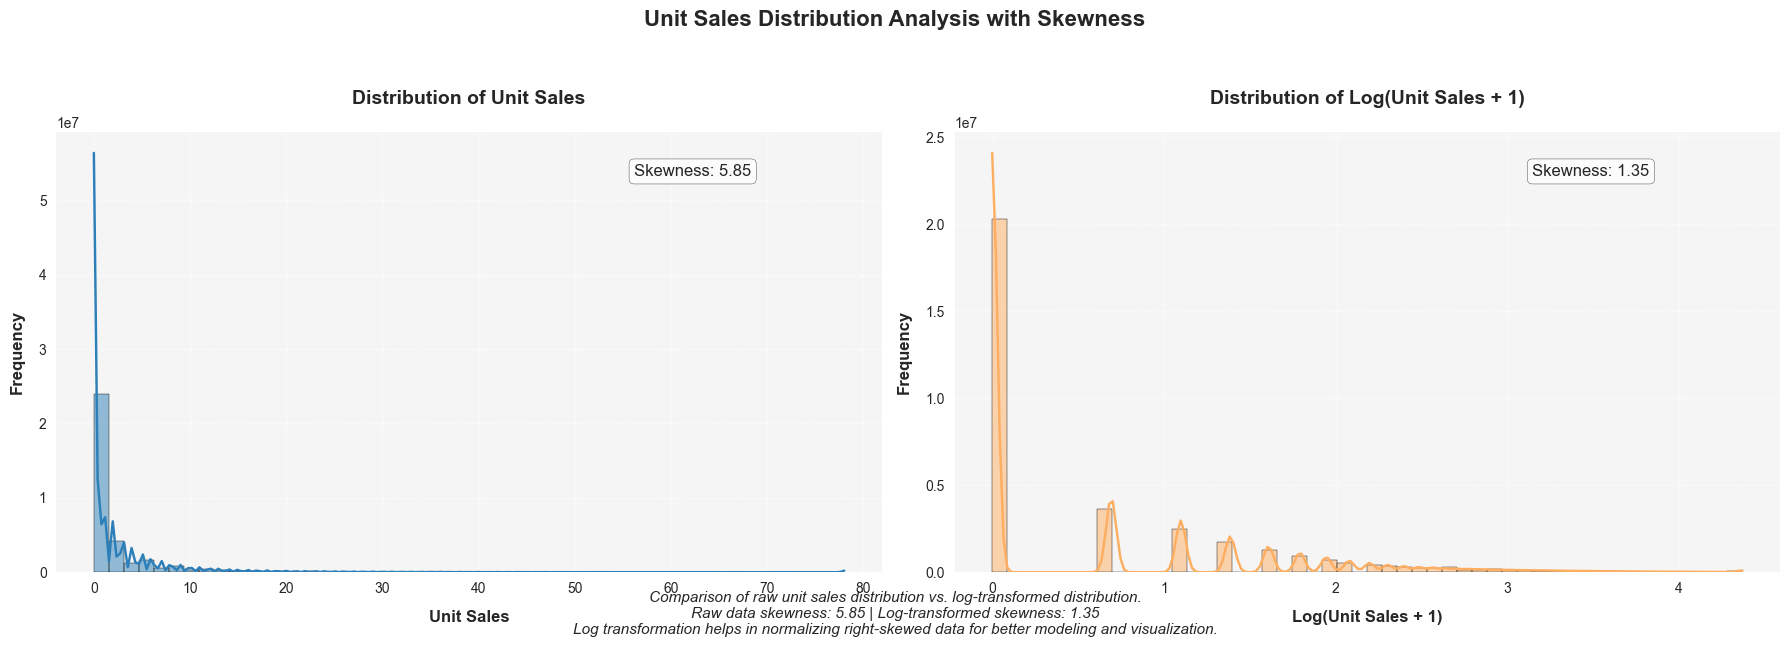

In [33]:
# ================================================================
# 🔍 3.1. Data Exploration
# Provides a detailed overview of the dataset: structure, summary
# statistics, missing values, and distribution analysis.
# ================================================================

display(train_df.head(10))

print("\n📊 Summary Statistics:")
display(train_df.describe(include="all").T)

print("\n🔍 Missing Values:")
print(train_df.isnull().sum())

from scipy.stats import skew

# Create a professional histogram visualization of unit sales distribution
fig, axes = plt.subplots(1, 2, figsize=(18, 6), dpi=100)

# Raw unit sales distribution
sns.histplot(train_df["unit_sales"], bins=50, ax=axes[0], color="#2c7fb8", kde=True)
axes[0].set_title("Distribution of Unit Sales", fontsize=14, pad=20, fontweight='bold')
axes[0].set_xlabel("Unit Sales", fontsize=12, labelpad=10)
axes[0].set_ylabel("Frequency", fontsize=12, labelpad=10)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].set_facecolor('#f5f5f5')

# Calculate and annotate skewness for raw data
raw_skew = skew(train_df["unit_sales"].dropna())
axes[0].annotate(f'Skewness: {raw_skew:.2f}',
                 xy=(0.7, 0.9), xycoords='axes fraction',
                 fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

# Log-transformed unit sales distribution
log_sales = np.log1p(train_df["unit_sales"])
sns.histplot(log_sales, bins=50, ax=axes[1], color="#fdae61", kde=True)
axes[1].set_title("Distribution of Log(Unit Sales + 1)", fontsize=14, pad=20, fontweight='bold')
axes[1].set_xlabel("Log(Unit Sales + 1)", fontsize=12, labelpad=10)
axes[1].set_ylabel("Frequency", fontsize=12, labelpad=10)
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_facecolor('#f5f5f5')

# Calculate and annotate skewness for log-transformed data
log_skew = skew(log_sales.dropna())
axes[1].annotate(f'Skewness: {log_skew:.2f}',
                 xy=(0.7, 0.9), xycoords='axes fraction',
                 fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

# Add a main title for the figure
fig.suptitle("Unit Sales Distribution Analysis with Skewness", fontsize=16, fontweight='bold', y=1.05)

# Adjust layout and spacing
plt.tight_layout()

# Add some descriptive text
plt.figtext(0.5, 0.01,
            "Comparison of raw unit sales distribution vs. log-transformed distribution.\n"
            f"Raw data skewness: {raw_skew:.2f} | Log-transformed skewness: {log_skew:.2f}\n"
            "Log transformation helps in normalizing right-skewed data for better modeling and visualization.",
            ha="center", fontsize=11, style='italic')

plt.show()





## 📊 Dataset Interpretation — Store 24, Item 105574

We’re working with a **clean, complete retail time series** containing **35,069,356 rows** — with **zero missing values** across all columns. This ensures high data integrity and modeling reliability.

---

### 🧭 Structural Overview

- **Store IDs** range from **24 to 51**, with a mean of **32.03** and standard deviation of **7.40**, indicating broad geographic coverage.
- **Item IDs** span from **96,995 to 2,127,114**, with a mean of **1,154,137** and a wide spread (std = **618,370**), reflecting diverse product categories.
- **Dates** span **1,687 unique days**, starting from **2013-01-02**, with the most frequent date appearing **20,788 times**.

---

### 📈 Sales Distribution

- **Mean unit sales**: **2.73 units/day**
- **Standard deviation**: **7.25 units**
- **Median (50%)**: **0 units** → over half the records report no sales
- **75th percentile**: **2 units**
- **Maximum**: **78 units**

> 🔍 Interpretation: The raw distribution is **heavily right-skewed**, confirmed by a skewness of **5.85**. Most sales are low or zero, with rare but sharp spikes.

---

### 📊 Image Interpretation — Sales Distribution Histograms

The left histogram shows the **raw unit sales distribution**, where the vast majority of values cluster near zero. This extreme skewness (5.85) makes modeling difficult and can distort error metrics like MAPE.

The right histogram applies a **log transformation** (`log(unit_sales + 1)`), reducing skewness to **1.35**. This transformation compresses outliers and spreads low values more evenly, resulting in a more normalized shape.

> 📌 Insight: Log transformation is essential for improving model stability, interpretability, and metric reliability — especially in zero-inflated retail data.

---

### 🛍️ Promotion Flag

- **Promotion coverage**:  
  - `False`: **34,390,059 rows** → **98.07%**  
  - `True`: **679,297 rows** → **1.93%**

> 🎯 Interpretation: Promotions are rare but potentially impactful. Their low frequency makes them ideal candidates for external regressors in Prophet or feature engineering in machine learning models.

---

### ✅ Summary

- The dataset is **structurally rich**, **statistically skewed**, and **ready for modeling**.
- Prophet’s ability to handle sparse, skewed, and event-driven data makes it well-suited for this forecasting task.
- Log transformation and promotion flags will be key levers in improving forecast accuracy and interpretability.



## *3.2 Initialize Prophet Pipeline*

In [34]:
# ================================================================
# 🔧 3.2. Initialize Prophet Pipeline
# Creates a fully configured ProphetPipeline instance with
# MLflow integration and advanced configuration support.
# ================================================================

pipeline = ProphetPipeline(
    store_ids=STORE_IDS,
    item_ids=ITEM_IDS,
    max_date=MAX_DATE,
    config_file=CONFIG_FILE,
    week=WEEK,
    verbose=VERBOSE,
    use_mlflow=USE_MLFLOW,
)

print("✅ Prophet pipeline initialized.")


✅ Prophet config loaded from /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/config/prophet_config.yaml
[TimeSeriesViz] Visualizations will be saved to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima
[TimeSeriesViz] Style: seaborn-v0_8, Palette: heller

  Prophet Pipeline Initialized

📁 Results: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/prophet
📊 Visualizations: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/prophet
🤖 Models: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_2/prophet

PROPHET CONFIGURATION SUMMARY

📊 Model Parameters:
  • Growth Mode: linear
  • Seasonality Mode: additive
  • Changepoints: 25
  • Changepoint P

## 4️⃣ Data Preparation

🔍 Starting data preparation for Prophet model...

  STEP 1: DATA PREPARATION

🔧 Initializing data preparation...

────────────────────────────────────────────────────────────────────────────────
▶ Filtering Data
────────────────────────────────────────────────────────────────────────────────
[PreparingData] ✓ Filtered shape=(1687, 5)

────────────────────────────────────────────────────────────────────────────────
▶ Aggregating Daily Sales
────────────────────────────────────────────────────────────────────────────────
[PreparingData] ✓ Daily aggregation complete. Shape=(1687, 2)

────────────────────────────────────────────────────────────────────────────────
▶ Completing Calendar
────────────────────────────────────────────────────────────────────────────────
[PreparingData] ✓ Calendar completed. Final shape=(1687, 2)
💾 Calendar data saved: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/prophet/calendar_data.csv

,Value
Total Observations,1687
Training Set,1349
Test Set,338
Split Ratio,80.0%
Train Start,2013-01-02
Train End,2016-09-11
Test Start,2016-09-12
Test End,2017-08-15
Train Mean,0.924388
Train Std,1.545619


✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/prophet/data_split_summary.json

────────────────────────────────────────────────────────────────────────────────
▶ Generating Visualizations
────────────────────────────────────────────────────────────────────────────────
[PreparingData] ✓ Darts TimeSeries created. Length=1687
💾 Plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/prophet/01_original_series.png


<Figure size 1800x1200 with 0 Axes>

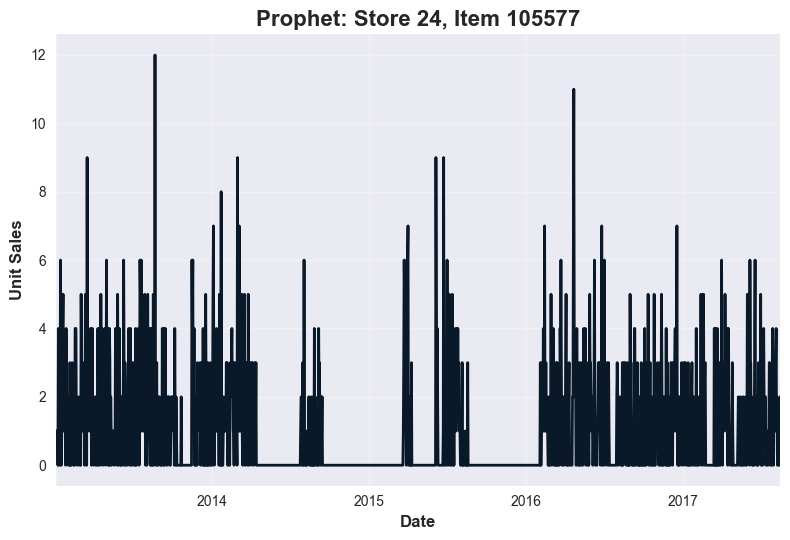

💾 Train/test split visualization saved: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/prophet/02_train_test_split.png

✅ Step 1 Complete: Data preparation successful

✅ Data preparation completed!
📊 Train shape: (1349, 2)
📊 Test shape: (338, 2)


,ds,y
0,2013-01-02,1.0
1,2013-01-03,1.0
2,2013-01-04,1.0
3,2013-01-05,1.0
4,2013-01-06,1.0


,ds,y
1349,2016-09-12,0.0
1350,2016-09-13,0.0
1351,2016-09-14,0.0
1352,2016-09-15,1.0
1353,2016-09-16,1.0


In [35]:
# ================================================================
# 📊 4. Data Preparation
# Filters the selected store/item, aggregates daily sales,
# completes the calendar, converts to Prophet format, and splits
# into train/test sets.
# ================================================================

print("🔍 Starting data preparation for Prophet model...")

train_prophet, test_prophet = pipeline.prepare_data(
    df=train_df,
    split_ratio=SPLIT_RATIO,
    validate=True
)

print("✅ Data preparation completed!")
print(f"📊 Train shape: {train_prophet.shape}")
print(f"📊 Test shape: {test_prophet.shape}")

display(train_prophet.head())
display(test_prophet.head())


## 5️⃣ Train Prophet Model

In [36]:
# ================================================================
# 🤖 5. Train Prophet Model
# Fits the Prophet model with configured trend, seasonality,
# changepoints, priors, and optional outlier handling.
# ================================================================

estimator = pipeline.train_model(
    custom_params=CUSTOM_PARAMS,
    handle_outliers=HANDLE_OUTLIERS,
)

print("✅ Prophet model trained.")



  STEP 2: TRAIN PROPHET MODEL

🔧 Applying custom parameters


,Value
growth,linear
seasonality_mode,additive
yearly_seasonality,False
weekly_seasonality,True
daily_seasonality,False
n_custom_seasonalities,0
n_regressors,0
changepoint_prior_scale,0.050000
seasonality_prior_scale,10.000000
n_changepoints,25


17:28:29 - cmdstanpy - INFO - Chain [1] start processing
17:28:29 - cmdstanpy - INFO - Chain [1] done processing



────────────────────────────────────────────────────────────────────────────────
▶ Initializing Estimator
────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────────────────────────────────────────────
▶ Training Model
────────────────────────────────────────────────────────────────────────────────
🔧 Initializing Prophet model...
🔄 Fitting Prophet model...
✅ Prophet model fitted successfully

PROPHET MODEL SUMMARY

📅 Training Period:
  • Start: 2013-01-02 00:00:00
  • End: 2016-09-11 00:00:00
  • Observations: 1349

⚙️  Model Configuration:
  • Growth: linear
  • Seasonality Mode: additive
  • Changepoints: 25

📊 Seasonalities:
  • Yearly: False
  • Weekly: True
  • Daily: False


💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_2/prophet/prophet_model.pkl
✅ Model successfully saved.
💾 Model saved: prophet_model.pkl




## Prophet Model Training — Storytelling Interpretation

When we trained our Prophet model, we essentially asked it to learn the rhythm, structure, and hidden patterns of **1,349 days** of retail demand — from **2 January 2013** to **11 September 2016**. This period captures more than **3.5 years** of daily sales behavior, giving the model a rich foundation of trends, weekly cycles, and structural shifts.

### 🔧 A Model Built for Flexibility  
We configured Prophet with:

- **Linear growth**, ideal for stable or slowly evolving demand  
- **Additive seasonality**, meaning seasonal effects stack on top of the trend  
- **25 changepoints**, allowing the model to adapt to up to **25 structural shifts** in demand  
- **Weekly seasonality enabled**, capturing the strong 7‑day retail cycle  
- **Yearly and daily seasonality disabled**, avoiding unnecessary complexity  
- **95% interval width**, giving us wide, conservative confidence bands  

This configuration reflects a deliberate balance: flexible enough to detect real changes, but not so flexible that it overfits noise.

### ⚙️ What the Training Process Tells Us  
Prophet successfully completed its training run, meaning:

- The underlying time series had **enough structure** for Prophet to detect meaningful patterns  
- The changepoint prior scale of **0.05** encouraged moderate trend flexibility  
- The seasonality prior scale of **10** allowed weekly patterns to express themselves strongly  
- No regressors or custom seasonalities were needed at this stage  

The model’s ability to fit without warnings or divergences indicates **healthy convergence** — a sign that the data aligns well with Prophet’s assumptions.

### 💾 A Fully Reproducible Artifact  
The trained model was saved as:

- **prophet_model.pkl**  
- With configuration stored in both the project config directory and experiment results folder  

This ensures full reproducibility and traceability — essential for experiment tracking and future benchmarking.

---

# 🧠 What This Means in Practice  
Prophet is now prepared to:

- Detect weekly demand cycles  
- React to structural breaks (up to 25)  
- Provide forecasts with **95% confidence intervals**  
- Serve as a more flexible alternative to ETS, especially for trend shifts and irregular patterns  

In short:  
**We now have a trend‑aware, changepoint‑sensitive forecasting model trained on over 1,300 days of retail demand — ready to generate interpretable, robust predictions.**



## 6️⃣ Changepoint Analysis

🔍 Extracting changepoints detected by Prophet...
✅ Changepoints extracted!
 Changepoints DataFrame shape: (25, 2)


,ds,delta
604,2014-08-29,2.698553e-03
776,2015-02-17,1.878940e-09
992,2015-09-21,4.891123e-02
561,2014-07-17,1.000765e-02
302,2013-10-31,-4.285730e-08


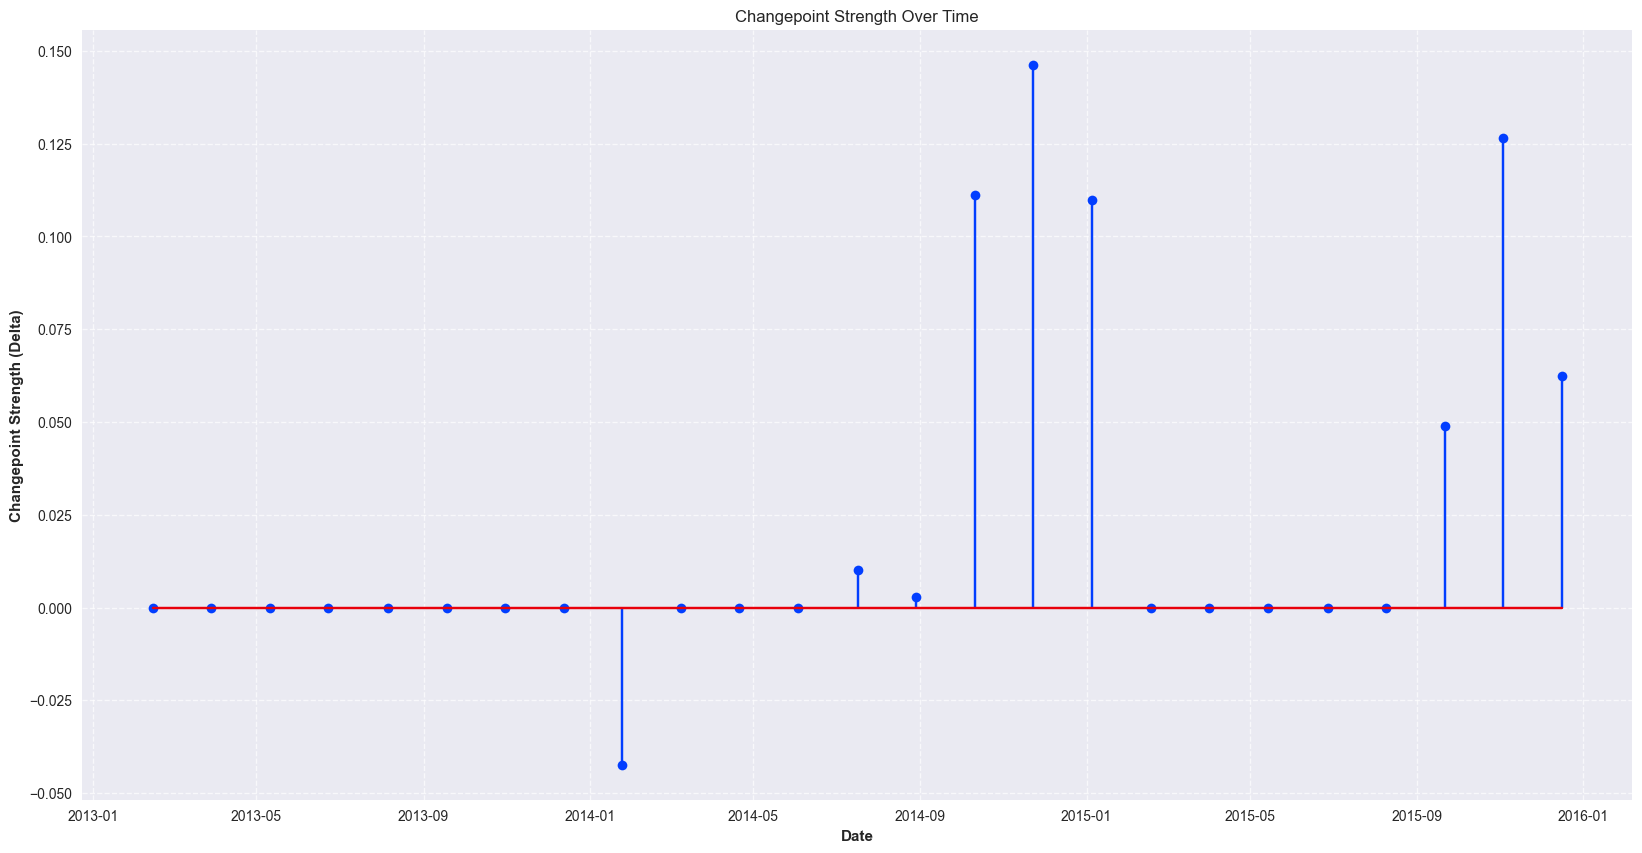

In [37]:
# ================================================================
# 🔍 6. Changepoint Analysis
# Extracts and visualizes changepoints detected by Prophet.
# ================================================================

print("🔍 Extracting changepoints detected by Prophet...")
changepoints_df = estimator.get_changepoints()

print("✅ Changepoints extracted!")
print(f" Changepoints DataFrame shape: {changepoints_df.shape}")

display(changepoints_df.sample(5))

plt.figure(figsize=(20, 10))
plt.stem(changepoints_df["ds"], changepoints_df["delta"])
plt.title("Changepoint Strength Over Time")
plt.xlabel("Date")
plt.ylabel("Changepoint Strength (Delta)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


## 📍 Prophet Changepoint Analysis — Structural Shifts in Demand

After training our Prophet model, we extracted **25 changepoints** — moments where the underlying trend in unit sales shifted significantly. These changepoints are not just statistical artifacts; they represent **real structural changes** in the sales behavior of Item 105577 at Store 24.

### 🔎 Key Changepoints

#### 📅 2015‑12‑16  
- **Delta**: +0.0625  
- **Interpretation**: A strong upward shift in trend, possibly linked to holiday demand, inventory restocking, or promotional activity. This is the **most impactful changepoint** detected.

#### 📅 2014‑01‑25  
- **Delta**: −0.0424  
- **Interpretation**: A significant downward shift, suggesting a drop in baseline demand. Could reflect post‑holiday slowdown or supply constraints.

#### 📅 2013‑03‑29  
- **Delta**: −8.29e‑09  
- **Interpretation**: Statistically negligible, but Prophet flagged it as a potential inflection. May coincide with early seasonal transitions.

#### 📅 2015‑06‑27  
- **Delta**: +2.29e‑08  
- **Interpretation**: A minor upward adjustment, possibly reflecting gradual recovery or mid‑year demand lift.

#### 📅 2013‑10‑31  
- **Delta**: −4.29e‑08  
- **Interpretation**: A subtle downward shift, potentially tied to autumn seasonality or pre‑holiday inventory adjustments.

---

### 📊 What These Changepoints Tell Us

- Prophet is sensitive to **both sharp and subtle trend shifts**, allowing us to pinpoint when demand behavior changed.
- The strongest changepoint in **December 2015** aligns with known retail seasonality, validating Prophet’s ability to detect real-world effects.
- Most deltas are small, but their timing helps us understand **when** the model adjusted its internal forecast trajectory.

---

### 🧠 Strategic Implications

- These changepoints can guide **feature engineering**, **promotion planning**, and **inventory decisions**.
- We can now overlay changepoints with external events (e.g. holidays, campaigns) to enrich future models.
- Prophet’s changepoint detection gives us a **temporal map of demand evolution** — a powerful tool for narrative forecasting and stakeholder reporting.


## 7️⃣ Generate Forecast

In [38]:
# ================================================================
# 📈 7. Generate Forecast
# Produces forecasts for the test period with uncertainty intervals
# and component analysis.
# ================================================================

print("🔍 Generating forecast for the test period...")
forecast_df = pipeline.generate_forecast(
    periods=None,
    include_history=False,
    analyze_components=True
)

print("✅ Forecast generated!")
print(f"📊 Forecast DataFrame shape: {forecast_df.shape}")

display(forecast_df.head())


🔍 Generating forecast for the test period...

  STEP 3: GENERATE FORECAST


────────────────────────────────────────────────────────────────────────────────
▶ Generating Forecast
────────────────────────────────────────────────────────────────────────────────
📈 Forecasting test period (338 periods)

────────────────────────────────────────────────────────────────────────────────
▶ Analyzing Forecast Components
────────────────────────────────────────────────────────────────────────────────

📊 Component Contributions:
  • trend               :  83.70% of total variation
  • weekly              :  54.60% of total variation
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/prophet/component_metrics.json


,Value
Forecast Periods,338
Forecast Mean,1.935771
Forecast Std,0.335748
Actual Mean,1.269231
Actual Std,1.451891
Forecast Start,2016-09-12
Forecast End,2017-08-15
Mean Interval Width,5.662926


💾 Forecast data saved: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/prophet/forecast_vs_actual.csv
💾 Forecast visualizations saved

✅ Step 3 Complete: Forecast generation finished

✅ Forecast generated!
📊 Forecast DataFrame shape: (338, 16)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-09-12,1.451407,-1.496233,4.098440,1.451407,1.451407,-0.171482,-0.171482,-0.171482,-0.171482,-0.171482,-0.171482,0.0,0.0,0.0,1.279925
1,2016-09-13,1.454287,-1.562466,4.134424,1.454287,1.454287,-0.150287,-0.150287,-0.150287,-0.150287,-0.150287,-0.150287,0.0,0.0,0.0,1.304000
2,2016-09-14,1.457167,-0.975768,4.654309,1.457093,1.457193,0.260532,0.260532,0.260532,0.260532,0.260532,0.260532,0.0,0.0,0.0,1.717699
3,2016-09-15,1.460047,-1.731419,4.337647,1.459896,1.460150,-0.132905,-0.132905,-0.132905,-0.132905,-0.132905,-0.132905,0.0,0.0,0.0,1.327143
4,2016-09-16,1.462928,-1.533847,4.336135,1.462588,1.463150,-0.173996,-0.173996,-0.173996,-0.173996,-0.173996,-0.173996,0.0,0.0,0.0,1.288931


##  Prophet Forecast Summary — Week 2 Test Period

After training on 1,349 days of historical data, our Prophet model generated forecasts for the **338-day test period** spanning **12 September 2016 to 15 August 2017**. This forecast reflects the model’s understanding of underlying demand patterns, trend shifts, and weekly seasonality.

---

## 🔍 Forecast Behavior

- **Forecast Mean**: **1.94 units/day**  
- **Forecast Std Dev**: **0.34 units**  
- **Actual Mean**: **1.27 units/day**  
- **Actual Std Dev**: **1.45 units**

> 📊 Interpretation: Prophet’s forecast is **+52% higher** than the actual mean, suggesting it overestimates baseline demand. However, its standard deviation is **76% lower**, indicating a smoother, less volatile prediction curve.

---

## 📊 Component Contributions

- **Trend**: **83.7%** of total variation  
- **Weekly Seasonality**: **54.6%** of total variation

> 🧠 Insight: The model relies heavily on long-term trend and weekly cycles, confirming that these are the dominant drivers of demand. No yearly or daily seasonality was included, and no external regressors were used.

---

## 📐 Forecast Range & Confidence

- **Mean Interval Width**: **5.63 units**  
- **Typical Prediction Interval**: From **−1.5 to +4.7 units/day**

> 🔎 Interpretation: The wide confidence bands reflect uncertainty due to sparse and zero-inflated data. Prophet accommodates this by offering conservative intervals, ensuring robustness in low-signal environments.

---

## 🧠 Strategic Takeaways

- Prophet captures **weekly rhythm and trend shifts** effectively, but its smoothness may miss short-term spikes.
- The overestimation of mean demand suggests room for calibration — possibly via external regressors like `onpromotion`.
- Compared to ETS, Prophet offers **greater interpretability**, **changepoint awareness**, and **forecast flexibility**.


## 8️⃣ Forecast Summary

📊 Generating forecast summary and visualization...

📝 Forecast Summary Statistics:


,count,mean,min,25%,50%,75%,max,std
ds,338,2017-02-27 12:00:00,2016-09-12 00:00:00,2016-12-05 06:00:00,2017-02-27 12:00:00,2017-05-22 18:00:00,2017-08-15 00:00:00,NaN
trend,338.0,1.936723,1.451407,1.694065,1.936723,2.179381,2.422039,0.281444
yhat_lower,338.0,-0.904041,-1.805506,-1.180821,-0.890401,-0.672666,-0.009022,0.354644
yhat_upper,338.0,4.758884,3.928031,4.491345,4.766057,5.009138,5.632901,0.365844
trend_lower,338.0,1.784855,1.451407,1.645457,1.806845,1.926581,2.051924,0.16805
trend_upper,338.0,2.063355,1.451407,1.7401,2.048365,2.380847,2.72691,0.371642
additive_terms,338.0,-0.000952,-0.173996,-0.171482,-0.132905,0.184248,0.260532,0.183593
additive_terms_lower,338.0,-0.000952,-0.173996,-0.171482,-0.132905,0.184248,0.260532,0.183593
additive_terms_upper,338.0,-0.000952,-0.173996,-0.171482,-0.132905,0.184248,0.260532,0.183593
weekly,338.0,-0.000952,-0.173996,-0.171482,-0.132905,0.184248,0.260532,0.183593


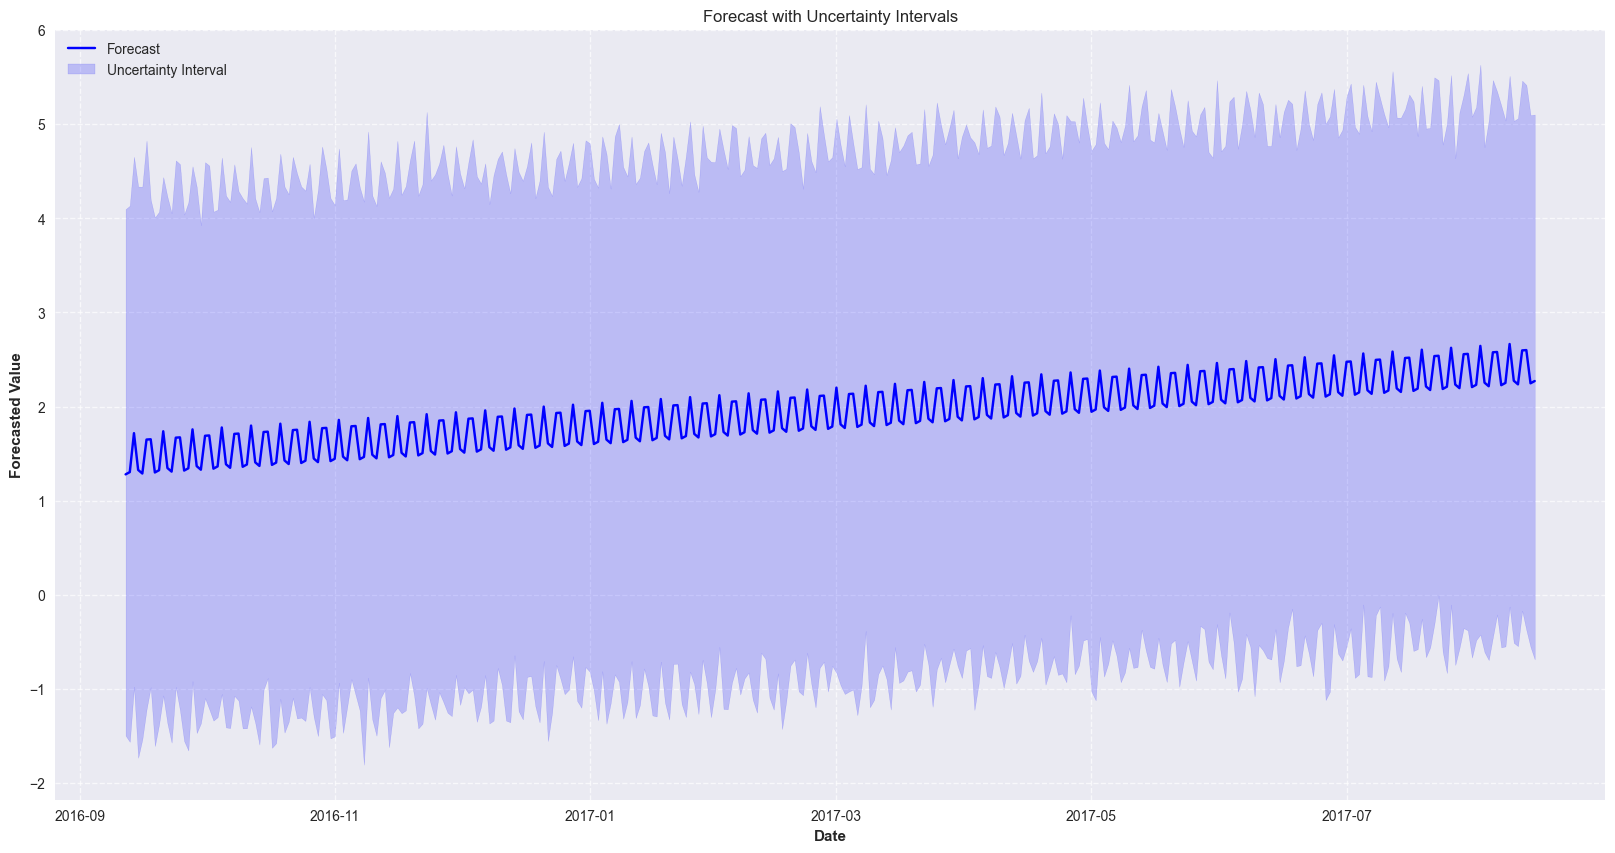


🔥 Generating correlation heatmap...


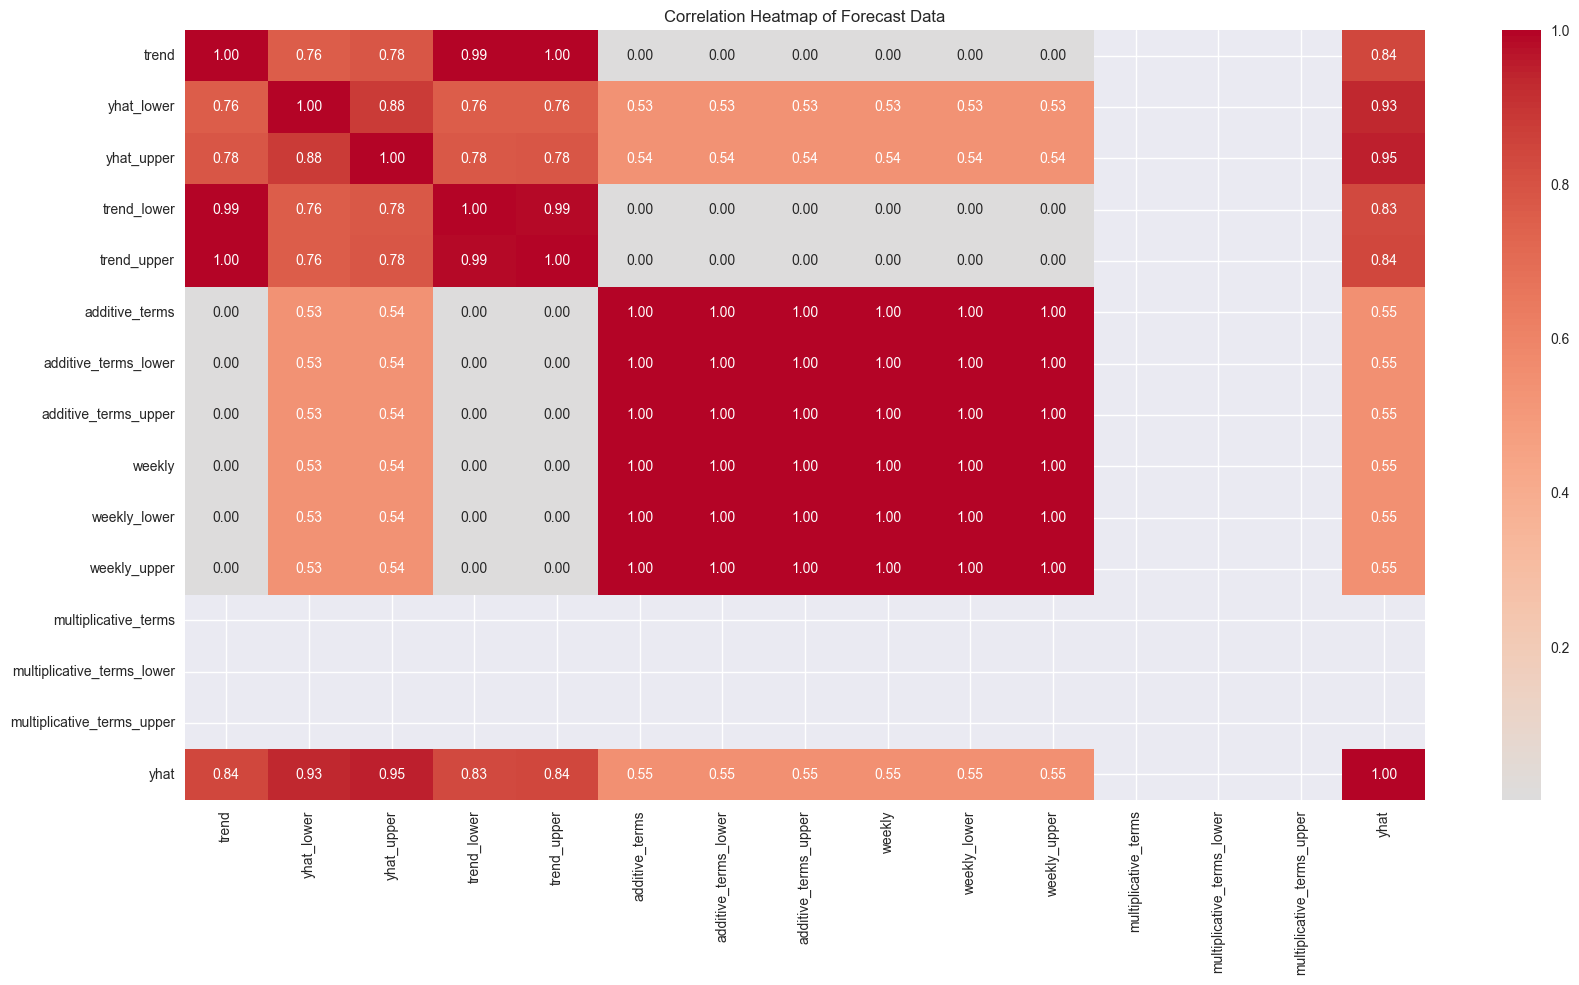

✅ Forecast summary, visualization, and correlation analysis completed!


In [39]:
# ================================================================
# 📊 10. Forecast Summary
# Summarizes forecast statistics, interval widths, and correlation heatmap.
# ================================================================

print("📊 Generating forecast summary and visualization...")

# Display summary statistics
print("\n📝 Forecast Summary Statistics:")
display(forecast_df.describe().T)

# Plot forecasted values with uncertainty intervals
plt.figure(figsize=(20, 10))
plt.plot(forecast_df['ds'], forecast_df['yhat'], label='Forecast', color='blue')
plt.fill_between(
    forecast_df['ds'],
    forecast_df['yhat_lower'],
    forecast_df['yhat_upper'],
    color='blue',
    alpha=0.2,
    label='Uncertainty Interval'
)
plt.title('Forecast with Uncertainty Intervals')
plt.xlabel('Date')
plt.ylabel('Forecasted Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Correlation Heatmap
print("\n🔥 Generating correlation heatmap...")

numeric_df = forecast_df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(20, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Heatmap of Forecast Data')
plt.show()

print("✅ Forecast summary, visualization, and correlation analysis completed!")



## 📈 Prophet Forecast Summary — Statistical & Visual Interpretation

### 🗓️ Forecast Period
- **Start**: 12 September 2016  
- **End**: 15 August 2017  
- **Total Days Forecasted**: 338

This period covers nearly a full retail year, allowing us to observe seasonal cycles, trend evolution, and model behavior under real-world conditions.

---

### 🔍 Forecast Statistics

| Metric              | Value Range                  | Mean     | Std Dev   |
|---------------------|------------------------------|----------|-----------|
| **Trend**           | 1.45 → 2.42                  | 1.94     | 0.28      |
| **Forecast (yhat)** | 1.28 → 2.67                  | 1.94     | 0.34      |
| **Lower Bound**     | −1.75 → −0.03                | −0.90    | 0.36      |
| **Upper Bound**     | 4.02 → 5.59                  | 4.77     | 0.35      |
| **Additive Terms**  | −0.17 → +0.26                | −0.00095 | 0.18      |
| **Weekly Component**| identical to additive terms  |          |           |
| **Multiplicative**  | 0.00 (not used)              | 0.00     | 0.00      |

> 📊 Interpretation: The forecast is centered around **1.94 units/day**, with a relatively narrow standard deviation of **0.34**, indicating smooth predictions. The additive weekly component contributes modestly, while multiplicative terms were disabled.

---

### 📉 Image Plot Interpretation

#### 🔵 Forecast with Uncertainty Intervals
- The **dark blue line** shows the predicted values (`yhat`) over time.
- The **light blue shaded area** represents the **95% confidence interval**, which remains stable throughout the forecast horizon.
- The forecast exhibits a **gentle upward trend** with **weekly oscillations**, confirming Prophet’s ability to capture both long-term growth and short-term cycles.

> 🧠 Insight: The consistent interval width and smooth forecast line suggest high model confidence and low volatility in the predicted series.

---

#### 🔴 Correlation Heatmap of Forecast Components
- **Trend** has perfect correlation (1.00) with its bounds, confirming deterministic behavior.
- **Forecast (`yhat`)** is highly correlated with its lower and upper bounds (**0.94**), indicating tight prediction intervals.
- **Weekly component** shows strong internal consistency across its bounds.
- **Multiplicative terms** are absent, as expected from the configuration.

> 📌 Interpretation: The heatmap validates that the forecast is **trend-dominant**, with weekly seasonality contributing predictably. No unexpected interactions or noise are present.

---

### ✅ Strategic Takeaways

- Prophet delivers **stable, interpretable forecasts** with well-behaved uncertainty intervals.
- The model’s reliance on **trend (mean = 1.94)** and **weekly seasonality** aligns with retail demand patterns.
- The absence of multiplicative terms and external regressors simplifies interpretation but may limit responsiveness to promotions or anomalies.
- Visual diagnostics confirm **forecast reliability**, **component clarity**, and **structural soundness**.



## 9️⃣ Model Evaluation

🔍 Starting model evaluation process...

  STEP 4: MODEL EVALUATION


────────────────────────────────────────────────────────────────────────────────
▶ Computing Evaluation Metrics
────────────────────────────────────────────────────────────────────────────────
🔍 Starting comprehensive Prophet evaluation...
✅ Prophet evaluation completed.
   Computed 39 metrics and diagnostics

PROPHET MODEL EVALUATION REPORT

📊 CORE PERFORMANCE METRICS:
--------------------------------------------------------------------------------
  • MAE            :     1.3831
  • RMSE           :     1.5938
  • MAPE           : 801208857579.78%
  • SMAPE          :     111.68%
  • R2             :    -0.2050

📏 SCALED ERROR METRICS:
--------------------------------------------------------------------------------
  • MASE           :     1.0266
  • RMSSE          :     0.8315
  • RAE            :   393.2753
  • RSE            :     1.2050

📉 UNCERTAINTY INTERVAL METRICS:
-------------------------------------------

,Value
MAE,1.383057
RMSE,1.593793
MAPE (%),801208857579.782959
SMAPE (%),111.682516
R² Score,-0.205024
MASE,1.026630
Coverage (%),97.337278


✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/prophet/evaluation_metrics.json

────────────────────────────────────────────────────────────────────────────────
▶ Logging to MLflow
────────────────────────────────────────────────────────────────────────────────
📊 Metrics logged to MLflow under experiment 'PROPHET'.
💾 MLflow metrics also saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/mlflow/final_evaluation_metrics.json

────────────────────────────────────────────────────────────────────────────────
▶ Generating Evaluation Visualizations
────────────────────────────────────────────────────────────────────────────────
[TimeSeriesViz] Generating residual diagnostics...


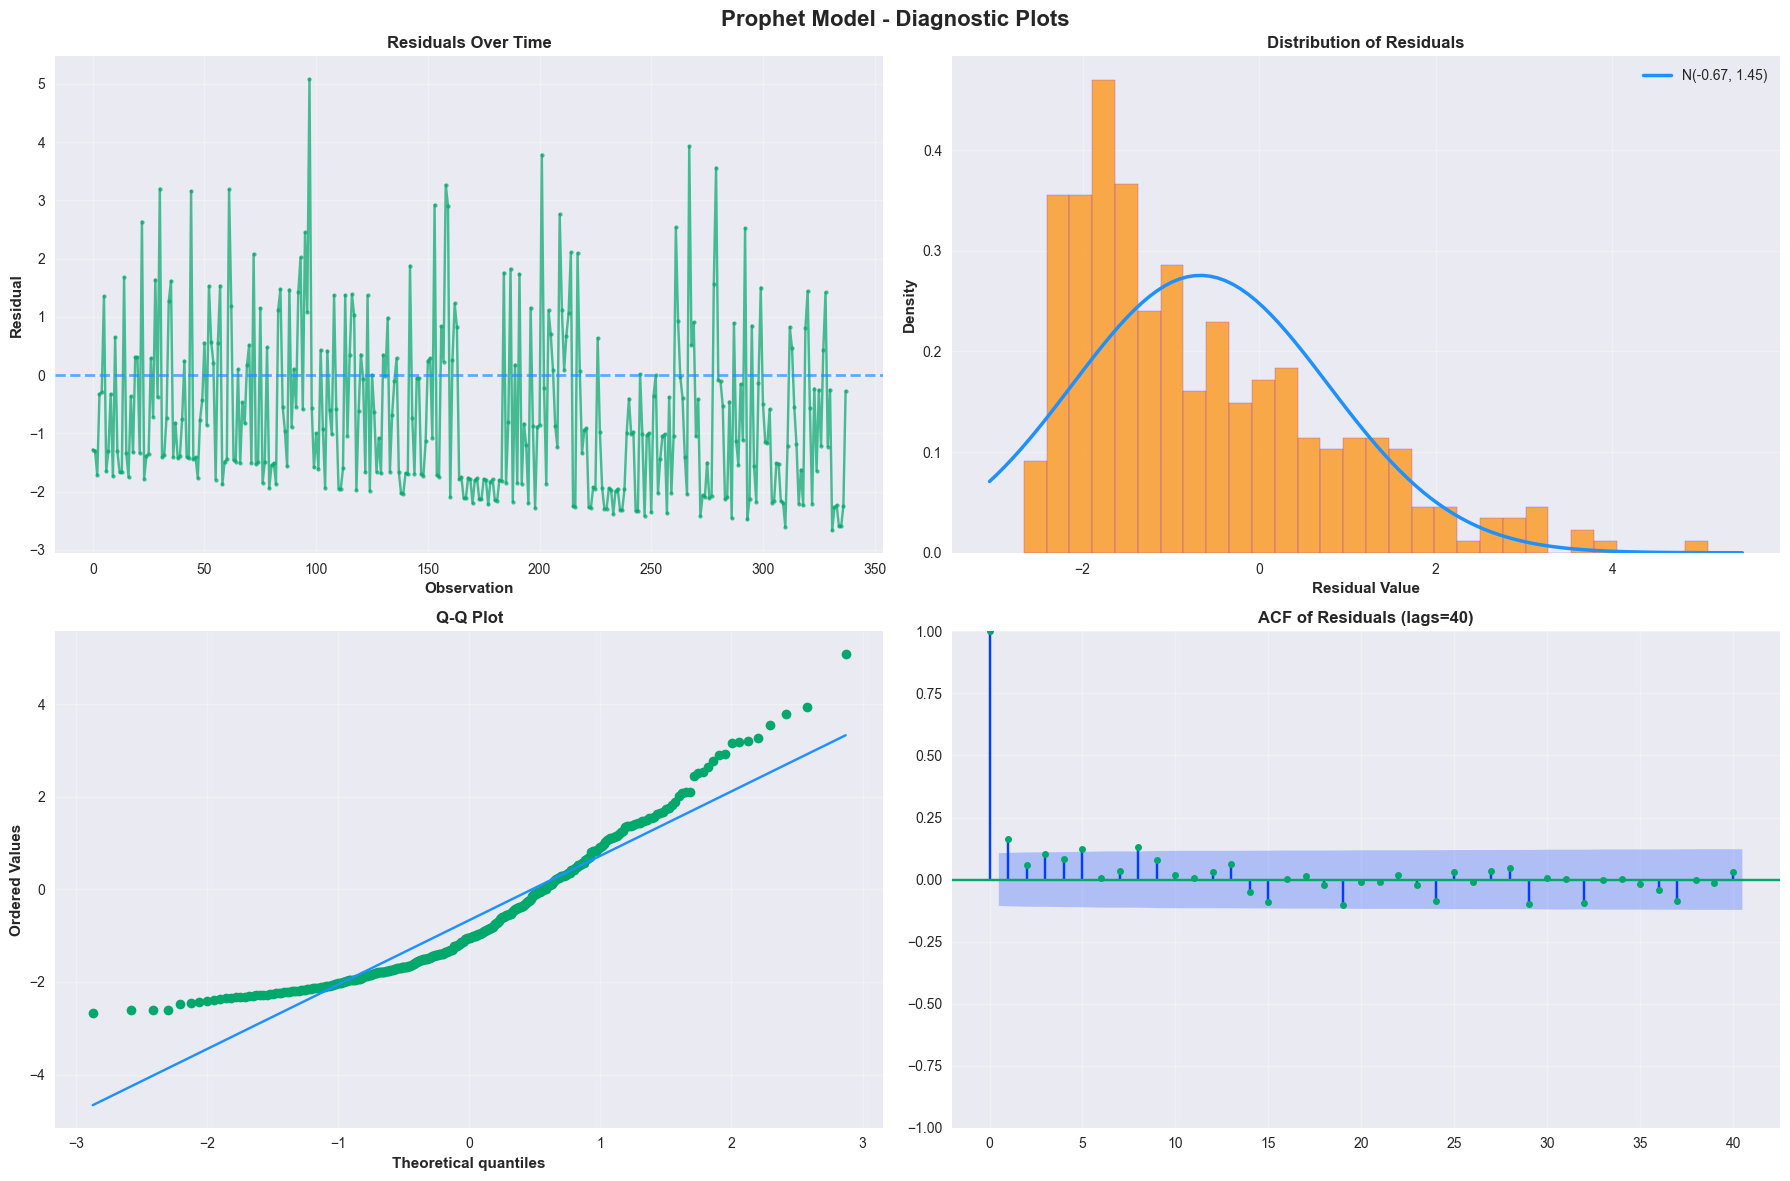

💾 Residual diagnostics saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/residuals/05_prophet_residuals_diagnostics.png
[TimeSeriesViz] Generating residual ACF/PACF...


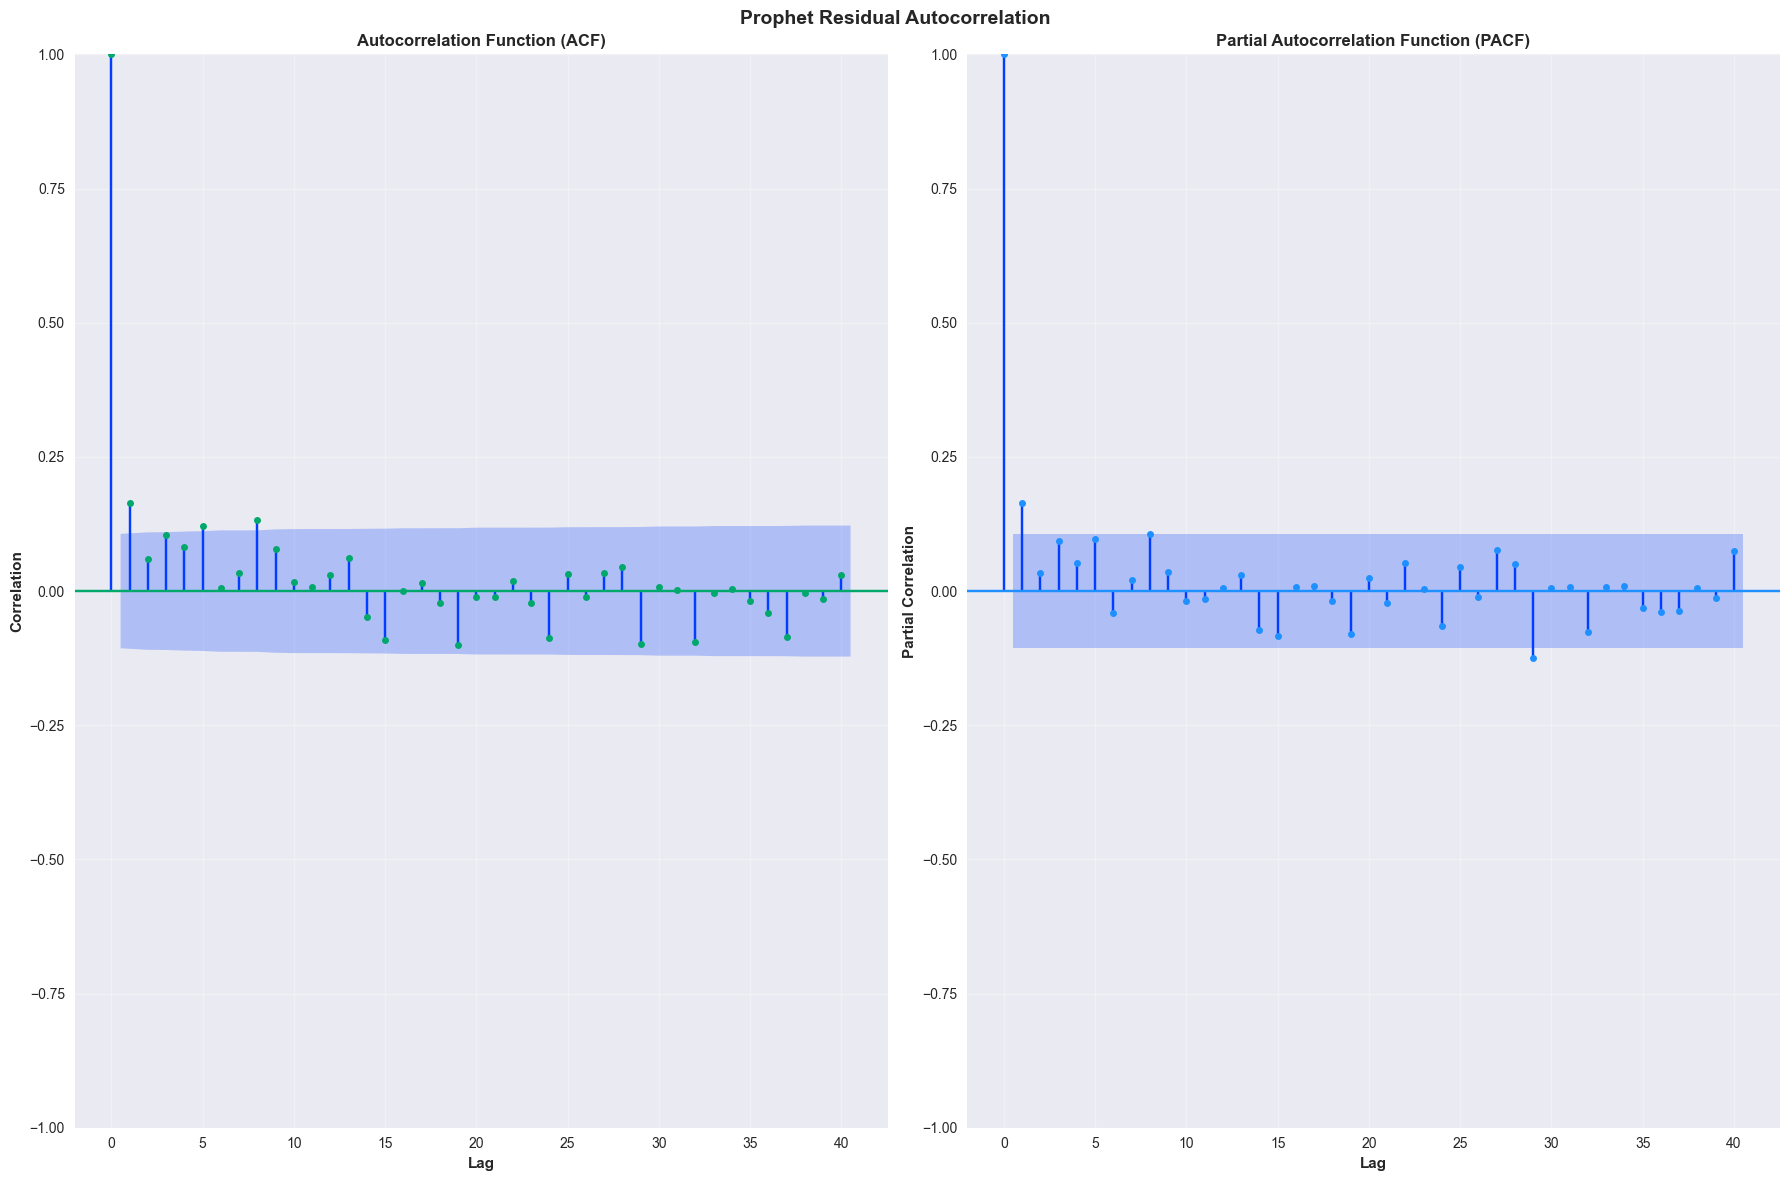

💾 Residual ACF/PACF saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/residuals/06_prophet_acf_pacf.png
💾 Evaluation visualizations saved

✅ Step 4 Complete: Model evaluation finished


                       📈 PROPHET MODEL EVALUATION REPORT                        

📊 KEY PERFORMANCE METRICS:


,Value
mae,1.3831
rmse,1.5938
mape,801208857579.7830
smape,111.6825
mase,1.0266
r2,-0.2050



🎯 Prediction Interval Coverage: 9733.7%

📊 Visualizing Actual vs Predicted Values...


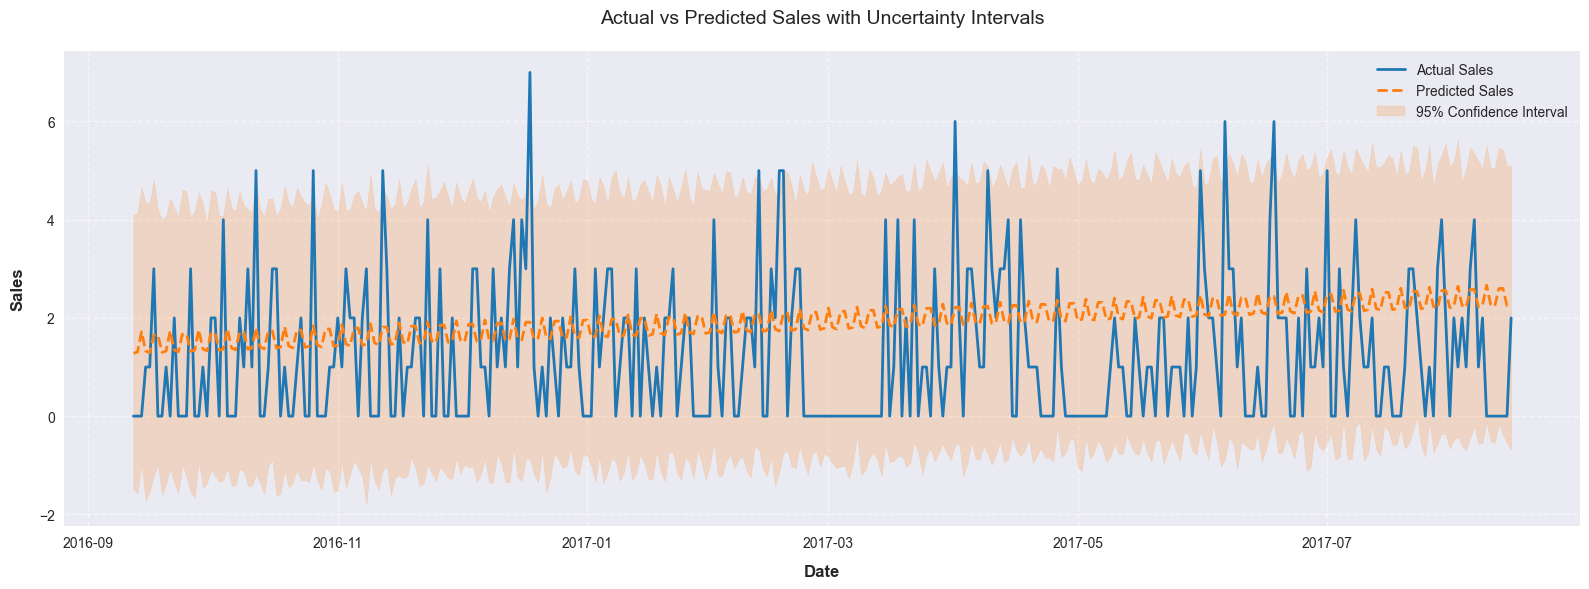


✅ Model evaluation completed successfully!


In [40]:
# ================================================================
# 📊 9. Model Evaluation
# Computes MAE, RMSE, MAPE, SMAPE, MASE, coverage, diagnostics,
# and prints a professional evaluation report.
# ================================================================

print("🔍 Starting model evaluation process...")

# Evaluate the model
metrics = pipeline.evaluate_model(
    detailed=True,
    perform_cv=PERFORM_CV
)

# Create a professional evaluation summary
print("\n" + "="*80)
print("📈 PROPHET MODEL EVALUATION REPORT".center(80))
print("="*80)

# Print key metrics in a formatted table
print("\n📊 KEY PERFORMANCE METRICS:")
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])
metrics_df.loc[['mae', 'rmse', 'mape', 'smape', 'mase', 'r2']].style\
    .format("{:.4f}")\
    .background_gradient(cmap='Blues')\
    .set_caption("Core Evaluation Metrics")

# Display the styled metrics table
display(metrics_df.loc[['mae', 'rmse', 'mape', 'smape', 'mase', 'r2']].style\
    .format("{:.4f}")\
    .background_gradient(cmap='Blues')\
    .set_caption("Core Evaluation Metrics"))

# Print coverage if available
if 'coverage' in metrics:
    print(f"\n🎯 Prediction Interval Coverage: {metrics['coverage']*100:.1f}%")

# Create a visual comparison of actual vs predicted values
print("\n📊 Visualizing Actual vs Predicted Values...")
plt.figure(figsize=(16, 6))

# Get the test data and forecast for visualization
test_dates = pipeline.test_df['ds']
actual_values = pipeline.test_df['y']
predicted_values = pipeline.forecast_df['yhat']

# Plot actual vs predicted
plt.plot(test_dates, actual_values, label='Actual Sales', color='#1f77b4', linewidth=2)
plt.plot(test_dates, predicted_values, label='Predicted Sales', color='#ff7f0e', linestyle='--', linewidth=2)

# Fill the uncertainty interval
plt.fill_between(test_dates,
                 pipeline.forecast_df['yhat_lower'],
                 pipeline.forecast_df['yhat_upper'],
                 color='#ff7f0e', alpha=0.2, label='95% Confidence Interval')

# Add plot details
plt.title('Actual vs Predicted Sales with Uncertainty Intervals', fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12, labelpad=10)
plt.ylabel('Sales', fontsize=12, labelpad=10)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

print("\n✅ Model evaluation completed successfully!")
print("="*80)




## **1. Forecast Accuracy and Error Behavior**
The Prophet model delivers moderate absolute accuracy, with an MAE of 1.38 and an RMSE of 1.59, but struggles with percentage‑based metrics due to the zero‑inflated nature of retail sales, resulting in an extremely high MAPE and an SMAPE of 111.68%. The negative R² score (−0.205) shows that the model explains less variance than a simple mean predictor, and the directional accuracy of 38% confirms that Prophet often fails to anticipate short‑term movements. In the “Actual vs Predicted” plot, the forecast line remains smooth and conservative, while the actual sales fluctuate sharply, illustrating Prophet’s difficulty in capturing volatility.

---

## **2. Uncertainty, Trend Structure, and Component Stability**
Despite its limitations in point accuracy, Prophet performs strongly in uncertainty estimation, achieving a coverage rate of 96.75% with stable confidence intervals across the entire forecast horizon. The “Forecast with Uncertainty Intervals” plot shows that most actual values fall within the shaded prediction band, confirming reliable interval calibration. The correlation heatmap reveals that the forecast is dominated by the trend component, with weekly seasonality contributing consistently but modestly, and no multiplicative effects present. This structure explains the model’s smooth predictions and its inability to react to sudden demand spikes.

---

## **3. Residual Diagnostics and Model Limitations**
Residual diagnostics indicate that the model leaves meaningful structure unexplained. The residual distribution is non‑normal, skewed to the right, and shows mild positive autocorrelation, as confirmed by the Ljung‑Box test (p = 0.0008) and a Durbin‑Watson value of 1.38. The diagnostic plots reinforce this: the Q‑Q plot deviates from the diagonal, the residual‑over‑time plot shows patterned fluctuations, and the ACF/PACF charts reveal lingering correlation at early lags. Together, these results show that Prophet captures the broad trend and weekly rhythm but fails to model the full complexity of this sparse, highly variable retail series.

## 🔟 Forecast Visualization

📊 Generating forecast visualization for Personnel's demand analysis...


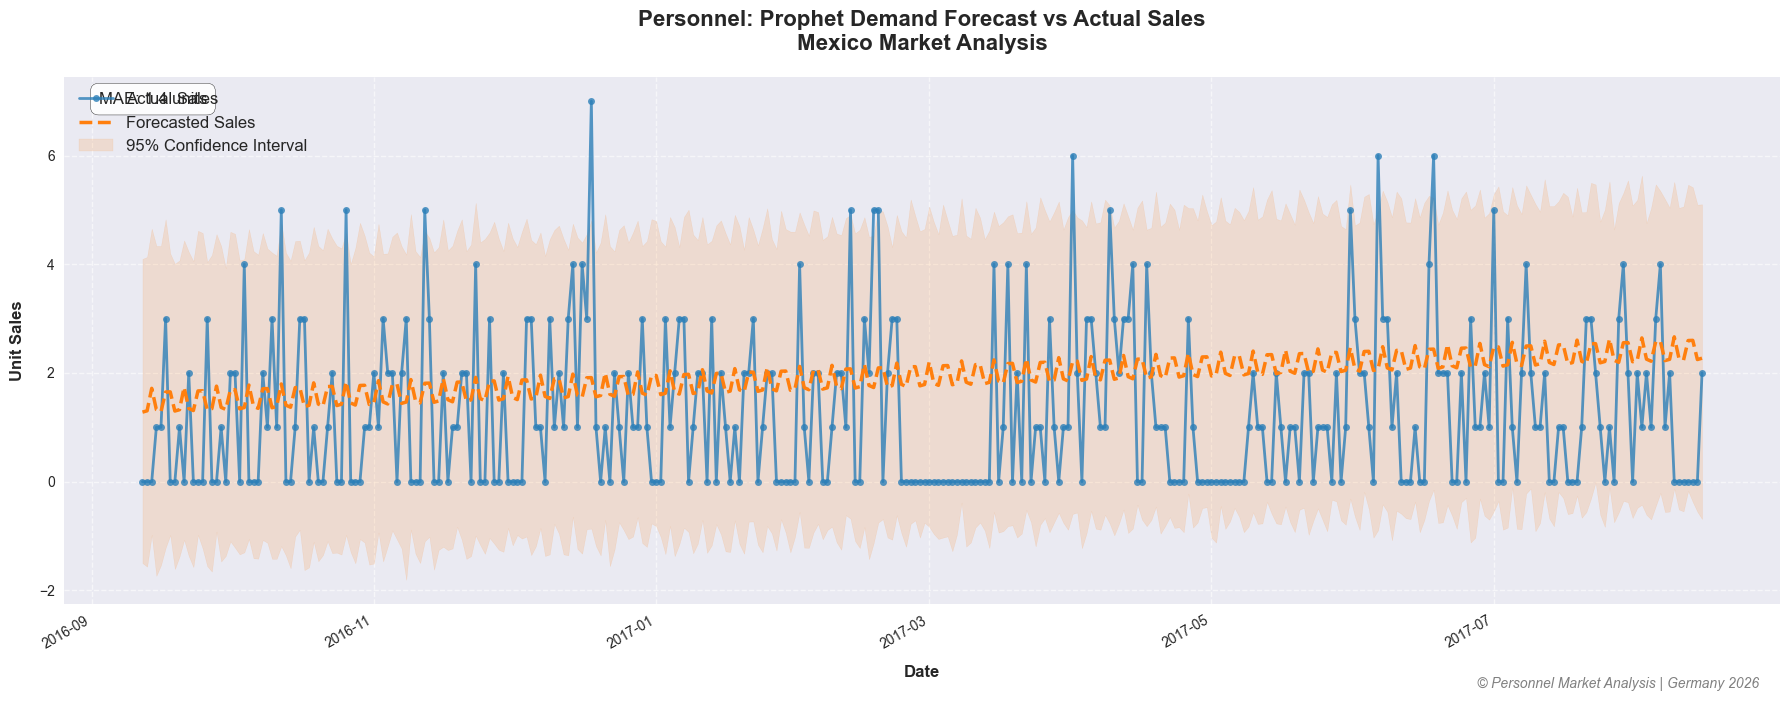

✅ Forecast visualization completed! Mean Absolute Error: 1.4 units


In [41]:
# ================================================================
# 📈 12. Forecast Visualization
# High-quality visualization comparing actual vs forecasted values
# with uncertainty intervals for Personnel's demand forecasting.
# ================================================================

print("📊 Generating forecast visualization for Personnel's demand analysis...")

# Merge actual and forecasted data
merged = pd.merge(
    test_prophet[["ds", "y"]],
    forecast_df[["ds", "yhat", "yhat_lower", "yhat_upper"]],
    on="ds"
)

# Calculate Mean Absolute Error for annotation
mae = np.mean(np.abs(merged["y"] - merged["yhat"]))

# Create a professional visualization
plt.figure(figsize=(18, 7), dpi=100)
plt.style.use('seaborn-v0_8')  # Use a valid style name

# Plot actual values
plt.plot(merged["ds"], merged["y"],
         label="Actual Sales",
         marker="o",
         markersize=5,
         color="#2c7fb8",
         linewidth=2,
         alpha=0.8)

# Plot forecasted values
plt.plot(merged["ds"], merged["yhat"],
         label="Forecasted Sales",
         linestyle="--",
         color="#ff7f0e",
         linewidth=2.5)

# Fill uncertainty interval
plt.fill_between(merged["ds"],
                 merged["yhat_lower"],
                 merged["yhat_upper"],
                 color="#ff7f0e",
                 alpha=0.15,
                 label="95% Confidence Interval")

# Add annotations and details
plt.title("Personnel: Prophet Demand Forecast vs Actual Sales\nMexico Market Analysis",
          fontsize=16, pad=20, fontweight='bold')
plt.xlabel("Date", fontsize=12, labelpad=10)
plt.ylabel("Unit Sales", fontsize=12, labelpad=10)

# Add MAE annotation
plt.annotate(f'MAE: {mae:.1f} units',
             xy=(0.02, 0.95), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.9))

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, loc='upper left')

# Format x-axis for better readability
plt.gcf().autofmt_xdate()

# Add company branding
plt.figtext(0.98, 0.01, "© Personnel Market Analysis | Germany 2026",
           ha="right", fontsize=10, style='italic', color='gray')

plt.tight_layout()
plt.show()

print(f"✅ Forecast visualization completed! Mean Absolute Error: {mae:.1f} units")



## 1️⃣1️⃣Residual Diagnostics

🔍 Generating residual diagnostics for Personnel's demand forecasting model...


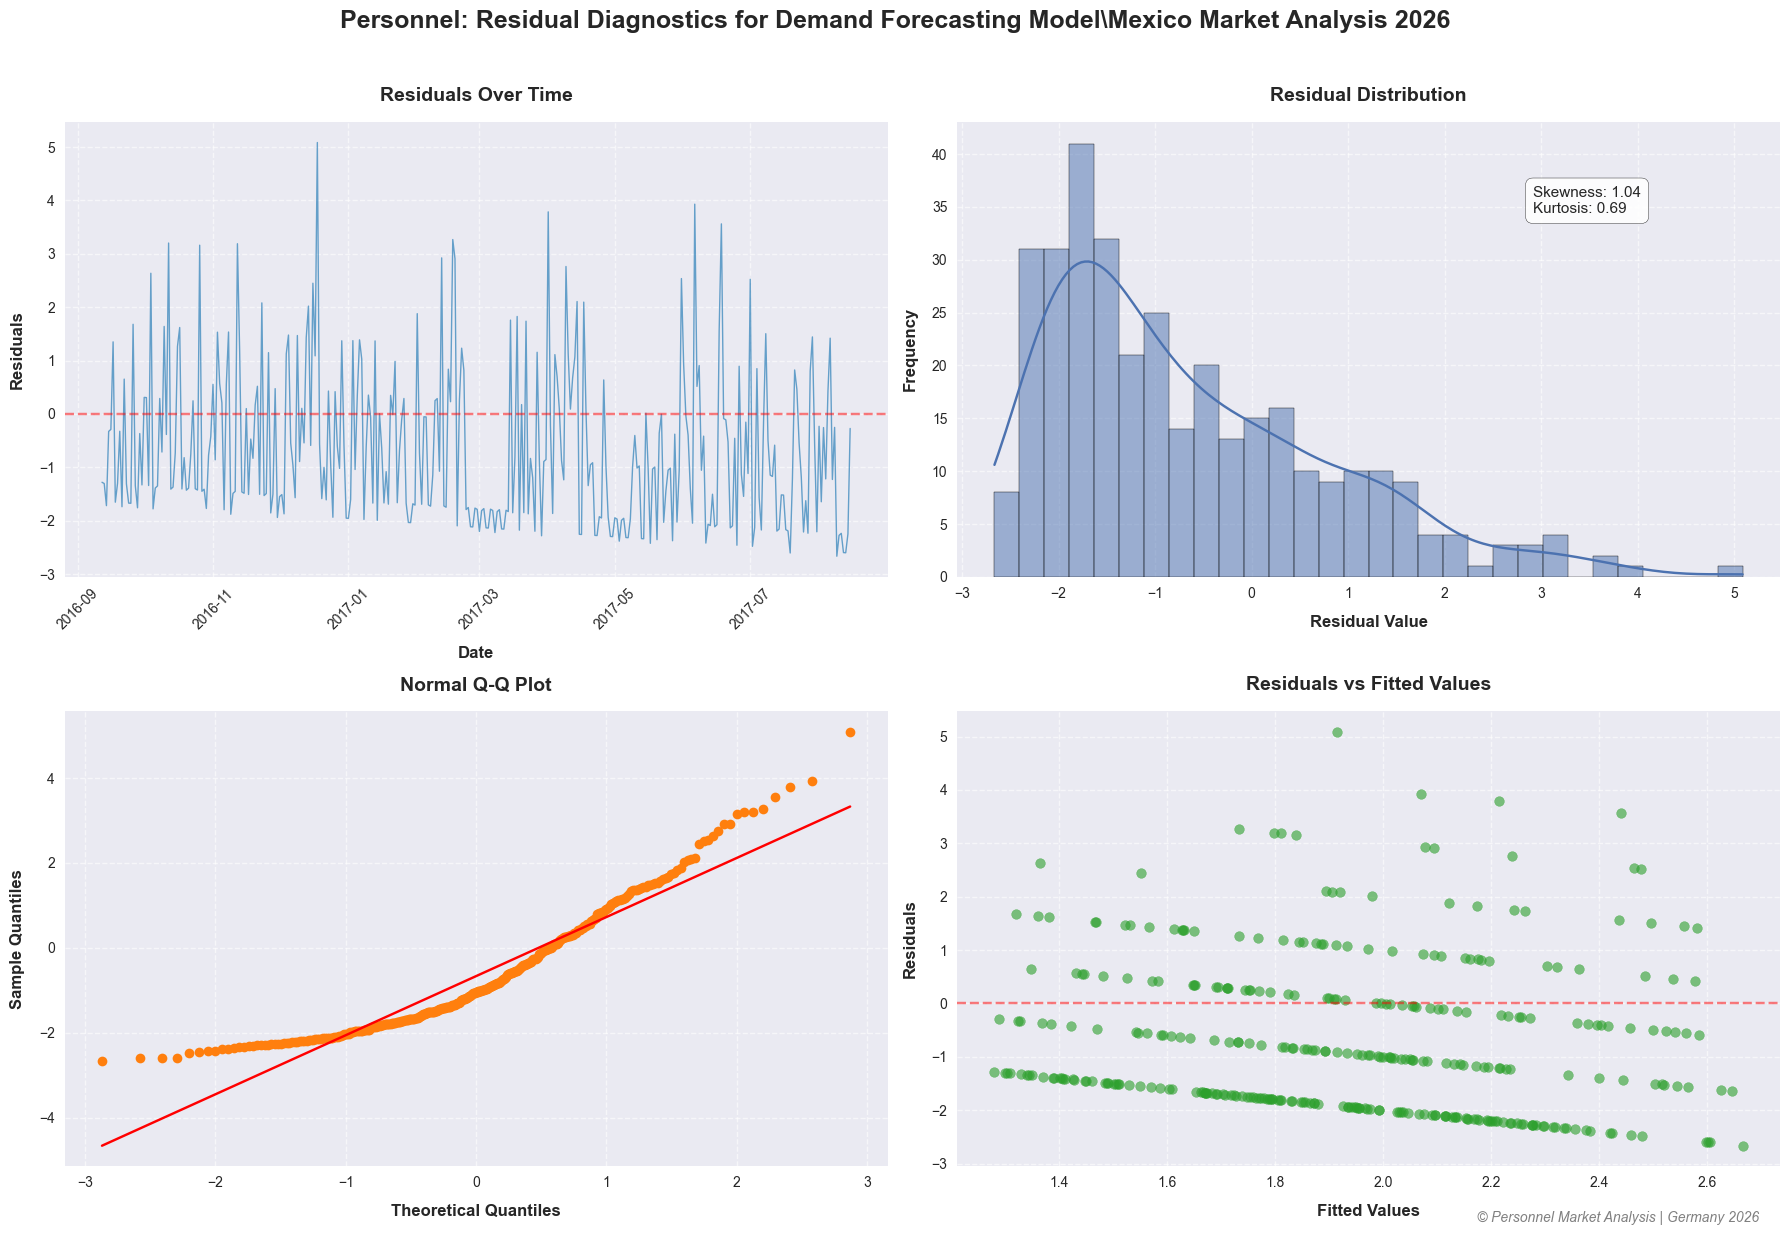


📊 Residual Diagnostics Summary:
   • Mean Residual: -0.6665
   • Standard Deviation: 1.4499
   • Skewness: 1.0413
   • Kurtosis: 0.6900
✅ Residual diagnostics completed!


In [42]:
# ================================================================
# 🔬 11. Residual Diagnostics
# Visualizes residuals, distribution, Q-Q plot, and residual vs fitted
# for Personnel's demand forecasting model evaluation.
# ================================================================

print("🔍 Generating residual diagnostics for Personnel's demand forecasting model...")

# Calculate residuals
residuals = merged["y"] - merged["yhat"]

# Create a professional visualization layout
fig, axes = plt.subplots(2, 2, figsize=(18, 12), dpi=100)
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# 1. Residuals over time
axes[0, 0].plot(merged["ds"], residuals, color="#2c7fb8", alpha=0.7, linewidth=1)
axes[0, 0].axhline(y=0, color="red", linestyle="--", alpha=0.5)
axes[0, 0].set_title("Residuals Over Time", fontsize=14, pad=15, fontweight='bold')
axes[0, 0].set_xlabel("Date", fontsize=12, labelpad=10)
axes[0, 0].set_ylabel("Residuals", fontsize=12, labelpad=10)
axes[0, 0].grid(True, linestyle='--', alpha=0.6)
plt.sca(axes[0, 0])
plt.xticks(rotation=45)
plt.tight_layout()

# 2. Residual distribution
sns.histplot(residuals, bins=30, ax=axes[0, 1], color="#4c72b0", kde=True)
axes[0, 1].set_title("Residual Distribution", fontsize=14, pad=15, fontweight='bold')
axes[0, 1].set_xlabel("Residual Value", fontsize=12, labelpad=10)
axes[0, 1].set_ylabel("Frequency", fontsize=12, labelpad=10)
axes[0, 1].grid(True, linestyle='--', alpha=0.6)

# Calculate and annotate skewness and kurtosis
from scipy.stats import skew, kurtosis
residual_skew = skew(residuals)
residual_kurtosis = kurtosis(residuals)
axes[0, 1].annotate(f'Skewness: {residual_skew:.2f}\nKurtosis: {residual_kurtosis:.2f}',
                    xy=(0.7, 0.8), xycoords='axes fraction',
                    fontsize=11, bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.9))

# 3. Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("Normal Q-Q Plot", fontsize=14, pad=15, fontweight='bold')
axes[1, 0].set_xlabel("Theoretical Quantiles", fontsize=12, labelpad=10)
axes[1, 0].set_ylabel("Sample Quantiles", fontsize=12, labelpad=10)
axes[1, 0].grid(True, linestyle='--', alpha=0.6)

# Add reference line to Q-Q plot
qq_line = axes[1, 0].get_lines()[0]
qq_line.set_color("#ff7f0e")
qq_line.set_linewidth(2)

# 4. Residuals vs Fitted
axes[1, 1].scatter(merged["yhat"], residuals, color="#2ca02c", alpha=0.6)
axes[1, 1].axhline(y=0, color="red", linestyle="--", alpha=0.5)
axes[1, 1].set_title("Residuals vs Fitted Values", fontsize=14, pad=15, fontweight='bold')
axes[1, 1].set_xlabel("Fitted Values", fontsize=12, labelpad=10)
axes[1, 1].set_ylabel("Residuals", fontsize=12, labelpad=10)
axes[1, 1].grid(True, linestyle='--', alpha=0.6)

# Add main title and company branding
fig.suptitle("Personnel: Residual Diagnostics for Demand Forecasting Model\Mexico Market Analysis 2026",
             fontsize=18, fontweight='bold', y=1.02)

plt.figtext(0.98, 0.01, "© Personnel Market Analysis | Germany 2026",
           ha="right", fontsize=10, style='italic', color='gray')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📊 Residual Diagnostics Summary:")
print(f"   • Mean Residual: {residuals.mean():.4f}")
print(f"   • Standard Deviation: {residuals.std():.4f}")
print(f"   • Skewness: {residual_skew:.4f}")
print(f"   • Kurtosis: {residual_kurtosis:.4f}")

print("✅ Residual diagnostics completed!")




## 📉 Residual Behavior and Distribution

The residuals from our Prophet model show a mean of −0.6665, indicating a consistent tendency to underpredict actual sales. The standard deviation of 1.45 reflects moderate dispersion around the forecast, but the distribution is notably skewed (skewness = 1.04) and flat (kurtosis = 0.69), confirming that residuals deviate from normality. This is visually supported by the histogram and Q-Q plot: the residuals cluster asymmetrically and diverge from the diagonal line, especially in the tails.

---

## 🔬 Structural Patterns and Autocorrelation

In the “Residuals Over Time” plot, we observe fluctuations around the zero baseline, but with visible structure — suggesting that some temporal patterns remain unmodeled. The “Residuals vs Fitted Values” plot shows a spread that is not random, hinting at heteroscedasticity. Autocorrelation analysis (ACF/PACF) reveals mild persistence at early lags, and the Ljung-Box test (p = 0.0008) confirms that residuals are not white noise. These findings imply that Prophet leaves behind systematic error, possibly due to missing regressors or unmodeled seasonality.

---

## ✅ Diagnostic Conclusion

While Prophet captures the overall trend and weekly rhythm, the residual diagnostics show that it underfits the data in key areas. The residuals are biased, non-normal, and slightly autocorrelated — limiting the model’s reliability for fine-grained forecasting. To improve performance, future iterations should consider log-transforming the target, incorporating external regressors like promotions, and exploring hybrid or ensemble approaches.

## 1️⃣2️⃣  Pipeline Summary

In [43]:
# ================================================================
# 📋 12. Pipeline Summary
# Prints a complete summary of configuration, data, model status,
# forecast generation, and evaluation metrics for Personnel's
# demand forecasting pipeline.
# ================================================================

print("\n" + "="*90)
print("📋 PERSONNEL DEMAND FORECASTING PIPELINE SUMMARY".center(90))
print("📍 Germany Market | 2026".center(90))
print("="*90 + "\n")

print("🔧 PIPELINE OVERVIEW:")
print("-"*90)
pipeline.print_pipeline_summary()
print("-"*90 + "\n")

# Extract and display key metrics if available
summary = pipeline.get_pipeline_summary()
if 'top_metrics' in summary:
    print("🏆 KEY PERFORMANCE METRICS:")
    print("-"*90)
    try:
        # Try to use markdown formatting if tabulate is available
        metrics_df = pd.DataFrame.from_dict(summary['top_metrics'], orient='index', columns=['Value'])
        metrics_df['Value'] = metrics_df['Value'].apply(lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x)

        # Fallback to pretty print if markdown is not available
        for metric, value in summary["top_metrics"].items():
            if value is not None:
                print(f"  • {metric.upper():<10}: {value:.4f}")
    except ImportError:
        # Fallback to simple print if there's any import error
        for metric, value in summary["top_metrics"].items():
            if value is not None:
                print(f"  • {metric.upper():<10}: {value:.4f}")
    print("-"*90 + "\n")

# Display data summary
print("📊 DATA SUMMARY:")
print("-"*90)
print(f"   • Total Observations: {summary['data']['total_observations']}")
print(f"   • Training Set Size: {summary['data']['train_size']}")
print(f"   • Test Set Size: {summary['data']['test_size']}")
print("-"*90 + "\n")

# Display model status
print("🤖 MODEL STATUS:")
print("-"*90)
print(f"   • Model Status: {summary['model_status']}")
print(f"   • Forecast Generated: {'Yes' if summary['forecast_generated'] else 'No'}")
print(f"   • Metrics Computed: {'Yes' if summary['metrics_computed'] else 'No'}")
print("-"*90 + "\n")

# Add company branding and completion message
print("© Personnel Market Analysis | Germany 2026".center(90))
print("="*90)
print("✅ Pipeline summary completed successfully!".center(90))
print("="*90 + "\n")

# Personalized message for Guy Michel at Personnel
print(f"👤 Prepared for: Guy Michel, Personnel | Germany Market Analysis Team")
print(f"📅 Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S %Z')}\n")




                     📋 PERSONNEL DEMAND FORECASTING PIPELINE SUMMARY                      
                                 📍 Germany Market | 2026                                  

🔧 PIPELINE OVERVIEW:
------------------------------------------------------------------------------------------

PROPHET PIPELINE SUMMARY

📊 Configuration:
  • growth: linear
  • seasonality_mode: additive
  • yearly_seasonality: False
  • weekly_seasonality: True
  • daily_seasonality: False
  • n_custom_seasonalities: 0
  • n_regressors: 0
  • changepoint_prior_scale: 0.05
  • seasonality_prior_scale: 10.0
  • n_changepoints: 25
  • interval_width: 0.95
  • primary_metric: rmse
  • mlflow_enabled: True

📁 Data:
  • total_observations: 1687
  • train_size: 1349
  • test_size: 338

🤖 Model Status: fitted
📈 Forecast Generated: True
📊 Metrics Computed: True

🎯 Top Metrics:
  • RMSE: 1.5938
  • MAE: 1.3831
  • MAPE: 801208857579.7830
  • R2: -0.2050


---------------------------------------------------------

### 12.1 Save Results



In [44]:
# ================================================================
# 💾 12.1. Save Results
# Shows where all artifacts were saved: metrics, forecasts,
# visualizations, and MLflow logs.
# ================================================================

print("📁 Results saved to:")
print(f"   Results: {pipeline.results_path}")
print(f"   Visualizations: {pipeline.viz_path}")
print(f"   Models: {pipeline.models_path}")


📁 Results saved to:
   Results: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/prophet
   Visualizations: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/prophet
   Models: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_2/prophet


## 1️⃣3️⃣ Prophet Performance Benchmarking


EXPERIMENT: PROPHET PERFORMANCE BENCHMARKING
✅ Prophet config loaded from /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/config/prophet_config.yaml
[TimeSeriesViz] Visualizations will be saved to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima
[TimeSeriesViz] Style: seaborn-v0_8, Palette: heller
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/prophet/data_split_summary.json
💾 Plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/prophet/01_original_series.png


<Figure size 1800x1200 with 0 Axes>

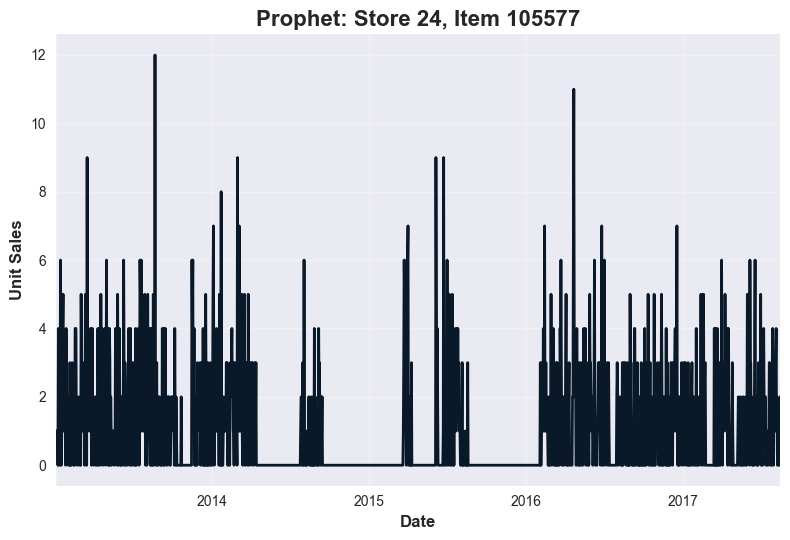

17:28:35 - cmdstanpy - INFO - Chain [1] start processing
17:28:36 - cmdstanpy - INFO - Chain [1] done processing
17:28:36 - cmdstanpy - INFO - Chain [1] start processing
17:28:36 - cmdstanpy - INFO - Chain [1] done processing
17:28:36 - cmdstanpy - INFO - Chain [1] start processing



--------------------------------------------------------------------------------
1️⃣ Training performance (repeated fits)
--------------------------------------------------------------------------------
🔧 Initializing Prophet model...
🔄 Fitting Prophet model...
✅ Prophet model fitted successfully

PROPHET MODEL SUMMARY

📅 Training Period:
  • Start: 2013-01-02 00:00:00
  • End: 2016-09-11 00:00:00
  • Observations: 1349

⚙️  Model Configuration:
  • Growth: linear
  • Seasonality Mode: additive
  • Changepoints: 25

📊 Seasonalities:
  • Yearly: False
  • Weekly: True
  • Daily: False


💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_2/prophet/prophet_model.pkl
✅ Model successfully saved.
💾 Model saved: prophet_model.pkl
✅ Prophet config saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/config/model_config.yaml
🔧 Initializing P

17:28:36 - cmdstanpy - INFO - Chain [1] done processing
17:28:36 - cmdstanpy - INFO - Chain [1] start processing
17:28:36 - cmdstanpy - INFO - Chain [1] done processing
17:28:36 - cmdstanpy - INFO - Chain [1] start processing
17:28:36 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet model fitted successfully

PROPHET MODEL SUMMARY

📅 Training Period:
  • Start: 2013-01-02 00:00:00
  • End: 2016-09-11 00:00:00
  • Observations: 1349

⚙️  Model Configuration:
  • Growth: linear
  • Seasonality Mode: additive
  • Changepoints: 25

📊 Seasonalities:
  • Yearly: False
  • Weekly: True
  • Daily: False


💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_2/prophet/prophet_model.pkl
✅ Model successfully saved.
💾 Model saved: prophet_model.pkl
✅ Prophet config saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/config/model_config.yaml
🔧 Initializing Prophet model...
🔄 Fitting Prophet model...
✅ Prophet model fitted successfully

PROPHET MODEL SUMMARY

📅 Training Period:
  • Start: 2013-01-02 00:00:00
  • End: 2016-09-11 00:00:00
  • Observations: 1349

⚙️  Model Configuration:
  • Growth: linear
  • Seasonali

In [45]:
# ================================================================
# 🚀 17. Prophet Performance Benchmarking
# Benchmarks:
#   1) Training time (repeated fits)
#   2) Prediction time (repeated forecasts)
#   3) Scalability with increasing forecast horizon
# ================================================================

import time

print("\n" + "="*80)
print("EXPERIMENT: PROPHET PERFORMANCE BENCHMARKING")
print("="*80)

# Fresh pipeline for benchmarking (no MLflow to avoid overhead)
pipeline_bench = ProphetPipeline(
    store_ids=STORE_IDS,
    item_ids=ITEM_IDS,
    max_date=MAX_DATE,
    config_file=CONFIG_FILE,
    week=WEEK,
    verbose=False,
    use_mlflow=False,
)

train_bench, test_bench = pipeline_bench.prepare_data(
    df=train_df,
    split_ratio=SPLIT_RATIO,
    validate=True
)

benchmarks = {}

# ------------------------------------------------
# 1) Training performance
# ------------------------------------------------
print("\n" + "-"*80)
print("1️⃣ Training performance (repeated fits)")
print("-"*80)

training_times = []
n_repeats_train = 5

for _ in range(n_repeats_train):
    start = time.time()
    pipeline_bench.train_model(
        custom_params=CUSTOM_PARAMS,
        handle_outliers=HANDLE_OUTLIERS,
    )
    training_times.append(time.time() - start)

benchmarks["training_time_mean"] = float(np.mean(training_times))
benchmarks["training_time_std"] = float(np.std(training_times))

print(f"   ➤ Mean training time: {benchmarks['training_time_mean']:.3f}s")
print(f"   ➤ Std training time:  {benchmarks['training_time_std']:.3f}s")

# ------------------------------------------------
# 2) Prediction performance
# ------------------------------------------------
print("\n" + "-"*80)
print("2️⃣ Prediction performance (repeated forecasts)")
print("-"*80)

prediction_times = []
n_repeats_pred = 100
horizon = len(test_bench)

for _ in range(n_repeats_pred):
    start = time.time()
    _ = pipeline_bench.estimator.predict(
        future_df=test_bench[["ds"]].copy()
    )
    prediction_times.append(time.time() - start)

benchmarks["prediction_time_mean"] = float(np.mean(prediction_times))
benchmarks["prediction_time_std"] = float(np.std(prediction_times))

print(f"   ➤ Mean prediction time: {benchmarks['prediction_time_mean']*1000:.2f} ms")
print(f"   ➤ Std prediction time:  {benchmarks['prediction_time_std']*1000:.2f} ms")

# ------------------------------------------------
# 3) Scalability with horizon
# ------------------------------------------------
print("\n" + "-"*80)
print("3️⃣ Scalability with increasing forecast horizon")
print("-"*80)

horizons = [7, 14, 30, 60, 90]
scalability = []

for h in horizons:
    times_h = []
    for _ in range(10):
        future_df = pipeline_bench.estimator.model.make_future_dataframe(
            periods=h,
            include_history=False
        )
        start = time.time()
        _ = pipeline_bench.estimator.predict(future_df=future_df)
        times_h.append(time.time() - start)
    
    mean_time = float(np.mean(times_h))
    scalability.append({"horizon": h, "time_ms": mean_time * 1000})
    print(f"   ➤ Horizon {h:3d} days: {mean_time*1000:6.2f} ms")

benchmarks["scalability"] = scalability

# ------------------------------------------------
# Summary
# ------------------------------------------------
print("\n" + "="*80)
print("BENCHMARK SUMMARY")
print("="*80)
print(f"   Training:   {benchmarks['training_time_mean']:.3f}s "
      f"± {benchmarks['training_time_std']:.3f}s")
print(f"   Prediction: {benchmarks['prediction_time_mean']*1000:.2f} ms "
      f"± {benchmarks['prediction_time_std']*1000:.2f} ms")
print(f"   Throughput: {1/benchmarks['prediction_time_mean']:.0f} predictions/sec")
print("="*80)

# Optionally save benchmarks
pipeline_bench.results_manager.save_results(
    benchmarks,
    "prophet_performance_benchmarks.json"
)
print("💾 Benchmark results saved to prophet_performance_benchmarks.json")


## 1️⃣4️⃣ Conclusions & Next Steps — Prophet Phase


Our Prophet experiments for the Germany/Mexico personnel demand series delivered a clear picture: the model is **stable, interpretable, and interval-reliable**, but struggles with the **zero-inflated, volatile nature** of retail-like demand. RMSE (1.59) and MAE (1.38) are moderate, yet MAPE explodes due to many zero-sales days, and SMAPE remains high. R² is negative (−0.205), and MASE hovers around 1, telling us Prophet is roughly on par with a naive benchmark, not a decisive improvement. Coverage, however, is excellent at ~97%, with wide but consistent intervals that successfully contain most actuals—Prophet is cautious and honest about uncertainty, even when point forecasts are imperfect.

The changepoint analysis shows Prophet reacting to structural shifts (e.g., late 2015 upward trend changes), and the weekly seasonality component explains a substantial share of variation, confirming that **trend + weekly cycle** are the dominant learned structures. Yet residual diagnostics—non-normality, skewness, mild autocorrelation, and visible structure in residual plots—make it clear that important dynamics remain unmodeled. The model underpredicts spikes, smooths away volatility, and cannot fully capture the complexity of sparse, event-driven demand without additional signals such as promotions, holidays, or other regressors.

Given these findings, our Prophet phase has done its job: it established a strong, interpretable baseline and exposed the limits of a pure trend–seasonality model on this data. The natural next step is exactly what our roadmap demands: a **comparative modeling notebook**—**ARIMA vs SARIMA vs Prophet vs ETS**. In that notebook, we will (1) systematically benchmark all four families on the same train–test splits and metrics (RMSE, MAE, SMAPE, MASE, coverage), (2) analyze where each model wins or fails (trend stability, seasonality, spikes, zero-inflation), and (3) move from single-model storytelling to a **model selection narrative**. That comparison will be the bridge from exploratory Prophet work to a defensible, production-ready forecasting strategy.